In [ ]:
import os
import tarfile
from google.colab import drive

drive_path = ('drive')
drive.mount(os.path.join(os.getcwd(), drive_path))

tar = tarfile.open('/content/drive/My Drive/Colab Notebooks/datasets/ChestX-ray8.tar', 'r')
tar.extractall(os.path.join(os.getcwd(), 'data'))

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git data/covid-chestxray-dataset
!cd data/covid-chestxray-dataset && git checkout fad61392f6e3c5a71fb3fb3a89f7d8dbd90b8730

HEAD is now at fad6139 refactor findings to include hierarchy


In [ ]:
!find data/covid-chestxray-dataset/images -type f | wc -l

910


In [ ]:
import os
drive_path = ('drive')
config = {
  'PATHS': {
    'RAW_DATA': os.path.join(os.getcwd(), 'data'),
    'COVID_CHEST_XRAY_DATA': os.path.join(os.getcwd(), 'data', 'covid-chestxray-dataset'),
    'CHEST_XRAY_8_DATA': os.path.join(os.getcwd(), 'data', 'ChestX-ray8'),
    'PROCESSED_DATA': os.path.join(os.getcwd(), 'data', 'processed'),
    'TRAIN_SET': os.path.join(os.getcwd(), 'data', 'processed', 'train_set.csv'),
    'VAL_SET': os.path.join(os.getcwd(), 'data', 'processed', 'val_set.csv'),
    'TEST_SET': os.path.join(os.getcwd(), 'data', 'processed', 'test_set.csv'),
    'IMAGES': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'output', 'documents', 'generated_images'),
    'LOGS': os.path.join(os.getcwd(), 'results', 'logs'),
    'CHECKPOINTS': os.path.join(os.getcwd(), 'model', 'checkpoints'),
    'MODELS_FOLDER': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid'),
    'MODEL_WEIGHTS': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid', 'model_weights20200531-103213.index'),
    'MODEL_TO_LOAD': '/content/drive/My Drive/model_covid/model20200905-193900.h5',
    #'MODEL_TO_LOAD': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid', 'model20200826-140506.h5'),
    'OUTPUT_CLASS_INDICES': os.path.join(os.getcwd(), 'data', 'interpretability', 'output_class_indices.pkl'),
    'LIME_EXPLAINER': os.path.join(os.getcwd(), 'data', 'interpretability', 'lime_explainer.pkl'),
    'UNET_MODEL_PATH': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'lung_segmentation', 'lung_segmentation_model.hdf5')
  },
  'DATA': {
    'IMG_DIM': tuple([331])*2,
    'VIEW': 'PA',
    'VAL_SPLIT_PERCENT': 0.08,
    'TEST_SPLIT_PERCENT': 0.1,
    'NUM_CHEST_XRAY_8_IMAGES': 1000,
    'CLASSES': [
      'NO FINDING',
      'COVID-19'
    ],
    'OTHER_CONTAINS_ONLY_HEALTHY': True,
    # One of {'class_weight', 'reduce'}
    'CLASS_BALANCE_STRATEGY': 'reduce'      
  },
  'SEGMENTATION': {
    'IMG_DIM': tuple([256])*2,
    'MORPHOLOGY_KERNEL_SIZE': tuple([5])*2,
    'DILATION_KERNEL_SIZE': tuple([2])*2,
    'DILATION_ITERATIONS': 3,
    'MASK_BINARIZATION_TRESHOLD': 0.25
  },
  'TRAIN': {
    'BATCH_SIZE': 8,
    'EPOCHS': 150,
    'THRESHOLDS': 0.5,
    'ENABLE_EARLY_STOPPING': True,
    'PATIENCE_FOR_EARLY_STOPPING': 10,
    'NUM_GPUS': 1
  },
  'NN': {
    'NODES_DENSE0': 256,
    'LR': 0.00001,
    'FT_LR': 0.000001,
    'OPTIMIZER': 'adam',
    'DROPOUT': 0.3,
    'L2_LAMBDA': 0.0001
  },
  'LIME': {
    'KERNEL_WIDTH': 4,
    'FEATURE_SELECTION': 'lasso_path',
    'NUM_FEATURES': 1000,
    'NUM_SAMPLES': 1000,
    'COVID_ONLY': False
  },
  'PREDICTION': {
    'THRESHOLD': 0.5
  }
}

In [ ]:
from pathlib import Path
import re

for path in config['PATHS']:
  if not bool(re.match('^.*\.[a-zA-Z0-9]+$', config['PATHS'][path])):
    Path(config['PATHS'][path]).mkdir(parents=True, exist_ok=True)
  else:
    splitted_path = config['PATHS'][path][:config['PATHS'][path].rfind('/')]
    Path(splitted_path).mkdir(parents=True, exist_ok=True)

In [ ]:
import pandas as pd

covid_chest_xray_path = config['PATHS']['COVID_CHEST_XRAY_DATA']
chest_xray_8_path = config['PATHS']['CHEST_XRAY_8_DATA']

covid_chest_xray_df = pd.read_csv(os.path.join(covid_chest_xray_path, 'metadata.csv'))
covid_chest_xray_df['filename'] = [os.path.join(covid_chest_xray_path, 'images', row) for row in covid_chest_xray_df['filename'].astype(str)]

covid_views_cxrs_df = covid_chest_xray_df['view'].str.match(config['DATA']['VIEW'])
covid_pos_df = covid_chest_xray_df['finding'].str.match('COVID-19')
covid_df = covid_chest_xray_df[covid_pos_df & covid_views_cxrs_df] 

chest_xray_8_df = pd.read_csv(os.path.join(chest_xray_8_path, 'subset.csv'))
num_chest_xray_8_imgs = config['DATA']['NUM_CHEST_XRAY_8_IMAGES']
chest_xray_8_normal_df = chest_xray_8_df[chest_xray_8_df['Finding Labels'].str.match('No Finding')]
chest_xray_8_pneum_df = chest_xray_8_df[chest_xray_8_df['Finding Labels'].str.match('(?!No Finding)')]

chest_xray_8_normal_sample_df = chest_xray_8_normal_df.sample(frac = num_chest_xray_8_imgs / chest_xray_8_normal_df.shape[0], random_state=num_chest_xray_8_imgs)

chest_xray_8_pneum_sample_df = chest_xray_8_pneum_df.sample(frac = num_chest_xray_8_imgs / chest_xray_8_pneum_df.shape[0], random_state=num_chest_xray_8_imgs)

if config['DATA']['OTHER_CONTAINS_ONLY_HEALTHY']:
  chest_xray_8_df = chest_xray_8_normal_sample_df
else:
  chest_xray_8_df = pd.concat([chest_xray_8_normal_sample_df, chest_xray_8_pneum_sample_df], axis=0)

chest_xray_8_df['filename'] = [os.path.join(chest_xray_8_path, row) for row in chest_xray_8_df['Image Index'].astype(str)]

In [ ]:
covid_df['label'] = 'COVID-19'
chest_xray_8_df['label'] = 'NO FINDING'

chest_xray_8_selected_df = None
if config['DATA']['CLASS_BALANCE_STRATEGY'] == 'reduce':
  chest_xray_8_selected_df = chest_xray_8_df.head(covid_df.shape[0])
else:
  chest_xray_8_selected_df = chest_xray_8_df

file_df = pd.concat(
        [covid_df[['filename', 'label']],
        chest_xray_8_selected_df[['filename', 'label']]], axis=0)         

In [ ]:
# from https://github.com/imlab-uiip/lung-segmentation-2d
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
UNet = load_model(config['PATHS']['UNET_MODEL_PATH'])

In [ ]:
import numpy as np
import pandas as pd
from skimage import morphology, color, io, exposure, transform

def mask_image(image, mask):
    """Returns masked image"""
    return np.ma.masked_where(mask == 0, image)
     

def remove_small_regions_and_dilate(image):
    """Morphologically removes small (less than kernel size) connected regions of 0s or 1s and dilates mask"""

    morphology_kernel = np.ones(config['SEGMENTATION']['MORPHOLOGY_KERNEL_SIZE'], np.uint8)
    dilation_kernel = np.ones(config['SEGMENTATION']['DILATION_KERNEL_SIZE'], np.uint8)
    image = np.squeeze(image).astype(np.float32)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, morphology_kernel)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, morphology_kernel)
    image = cv2.dilate(image, dilation_kernel, iterations = config['SEGMENTATION']['DILATION_ITERATIONS'])

    return image

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

masked_filenames = []

for row in file_df.iterrows():
  file_name = row[1][0]
  dot_index = file_name.rfind('.')
  masked_image_filename = '{}{}{}'.format(file_name[:dot_index], '_masked', file_name[dot_index:])
  mask_filename = '{}{}{}'.format(file_name[:dot_index], '_mask', file_name[dot_index:])
  original_image = cv2.imread(file_name, 0).astype(np.float32)/255.0
  original_image_size = original_image.shape[::-1]
  
  downsized_image = cv2.resize(original_image, dsize=config['SEGMENTATION']['IMG_DIM'], interpolation=cv2.INTER_CUBIC)
  downsized_image = np.expand_dims(downsized_image, axis=0)
  downsized_image = tf.image.per_image_standardization(downsized_image)

  mask_prediction = UNet.predict(downsized_image)

  mask = mask_prediction > config['SEGMENTATION']['MASK_BINARIZATION_TRESHOLD']
  mask = remove_small_regions_and_dilate(mask)
  upsized_mask = cv2.resize(np.squeeze(mask).astype(np.float32), dsize=original_image_size, interpolation=cv2.INTER_CUBIC)
  masked_image = mask_image(original_image, upsized_mask)
  cv2.imwrite(mask_filename, upsized_mask*255)
  cv2.imwrite(masked_image_filename, masked_image*255)
  masked_filenames.append(masked_image_filename)
  
file_df.insert(1, 'masked_filename', masked_filenames)

ValueError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

validation_split_size = config['DATA']['VAL_SPLIT_PERCENT']
test_split_size = config['DATA']['TEST_SPLIT_PERCENT']
file_df_train, file_df_test = train_test_split(file_df, test_size=test_split_size, stratify=file_df['label'], random_state=42)
relative_validation_split_size = validation_split_size / (1 - test_split_size)
file_df_train, file_df_val = train_test_split(file_df_train, test_size=relative_validation_split_size,
                                                    stratify=file_df_train['label'], random_state=42)

if not os.path.exists(config['PATHS']['PROCESSED_DATA']):
    os.makedirs(config['PATHS']['PROCESSED_DATA'])
file_df_train.to_csv(config['PATHS']['TRAIN_SET'])
file_df_val.to_csv(config['PATHS']['VAL_SET'])
file_df_test.to_csv(config['PATHS']['TEST_SET'])

ValueError: ignored

In [ ]:
import datetime
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(config['PATHS']['LOGS'], 'training', cur_date)
model_filename = 'weights.{epoch:02d}-{auc:.2f}.hdf5'
model_filename_single = 'weights.hdf5'
checkpoint_path = os.path.join(config['PATHS']['CHECKPOINTS'], model_filename)
print(checkpoint_path)
if not os.path.exists(os.path.join(config['PATHS']['LOGS'], 'training')):
    os.makedirs(os.path.join(config['PATHS']['LOGS'], 'training'))
    
data = {}
data['TRAIN'] = pd.read_csv(config['PATHS']['TRAIN_SET'])
data['VAL'] = pd.read_csv(config['PATHS']['VAL_SET'])
data['TEST'] = pd.read_csv(config['PATHS']['TEST_SET'])

callbacks = []
if config['TRAIN']['ENABLE_EARLY_STOPPING']:
  early_stopping = EarlyStopping(
    monitor='val_auc_pr',
    verbose=1, 
    patience=config['TRAIN']['PATIENCE_FOR_EARLY_STOPPING'], 
    mode='max', 
    restore_best_weights=True)
  callbacks.append(early_stopping)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks.append(tensorboard)
model_checkpoint = ModelCheckpoint(model_filename_single, 
                                   monitor='val_auc_pr', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch'
)
callbacks.append(model_checkpoint)

/content/model/checkpoints/weights.{epoch:02d}-{auc:.2f}.hdf5


Found 312 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.
Found 39 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.9984641   0.9984641   0.9984641 ]
  [ 0.9998075   0.9998075   0.9998075 ]
  [ 1.0011508   1.0011508   1.0011508 ]
  ...
  [-2.5847342  -2.5847342  -2.5847342 ]
  [-2.5649822  -2.5649822  -2.5649822 ]
  [-2.5452302  -2.5452302  -2.5452302 ]]

 [[ 0.9659642   0.9659642   0.9659642 ]
  [ 0.968651    0.968651    0.968651  ]
  [ 0.97133744  0.97133744  0.97133744]
  ...
  [-2.5833907  -2.5833907  -2.5833907 ]
  [-2.5636387  -2.5636387  -2.5636387 ]
  [-2.5438867  -2.5438867  -2.5438867 ]]

 [[ 0.90105563  0.90105563  0.90105563]
  [ 0.9064292   0.9064292   0.9064292 ]
  [ 0.9118024   0.9118024   0.9118024 ]
  ...
  [-2.5820475  -2.5820475  -2.5820475 ]
  [-2.5622954  -2.5622954  -2.5622954 ]
  [-2.5425432  -2.5425432  -2.5425432 ]]

 ...

 [[ 0.03864409  0.03864409  0.03864409]
  [ 0.25854835  0.25854835  0.25854835]
  [ 0.39457828  0.39457828  0.39457828]
  ...
  [-3.0472677  -3.0472677  -3.0472677 ]
  [-3.0472677  -3.0472677  -3.0472677 ]
  [-3.0472677  -3.0472677  -3.0472677 ]]

 [

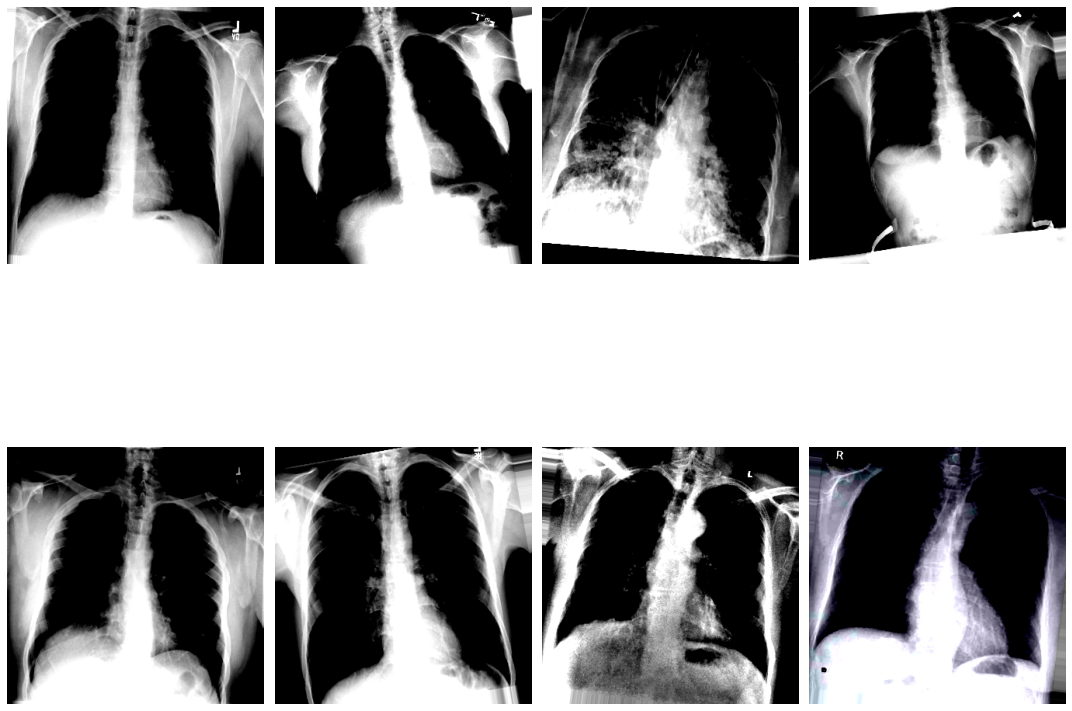

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import dill

train_img_gen = ImageDataGenerator(rotation_range=10, samplewise_std_normalization=True, samplewise_center=True)
val_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)
test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

class_mode = 'categorical'
train_generator = train_img_gen.flow_from_dataframe(
    dataframe=data['TRAIN'],
    x_col='filename',
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True)
val_generator = val_img_gen.flow_from_dataframe(
    dataframe=data['VAL'],
    x_col="filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True)
test_generator = test_img_gen.flow_from_dataframe(
    dataframe=data['TEST'],
    x_col="filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True,
    shuffle=False)

dill.dump(test_generator.class_indices, open(config['PATHS']['OUTPUT_CLASS_INDICES'], 'wb+'))

histogram = np.bincount(np.array(train_generator.labels).astype(int))

class_weight = None
if config['DATA']['CLASS_BALANCE_STRATEGY'] == 'class_weight':
  class_multiplier_list = [min(histogram) / max(histogram)]
  class_multiplier_list.insert(int(histogram[0] > histogram[1]), 1.0)

  class_multiplier = [
          class_multiplier_list[config['DATA']['CLASSES'].index(c)]
              for c in test_generator.class_indices
  ]

  weights = [(1.0 / len(histogram)) * sum(histogram) / histogram[i] for i in range(len(histogram))]

  class_weight = {i: class_multiplier[i] for i in range(len(histogram))}  

x,y = train_generator.next()
train_generator.reset()

fig,ax=plt.subplots(2,4)
fig.set_size_inches(15,15)
num = 0
for i in range(2):
  for j in range(4):
    print(x[num])
    ax[i,j].imshow(x[num])
    ax[i,j].axis('off')
    num += 1
        
plt.tight_layout()

In [ ]:
!rm -R /content/results

In [ ]:
from tensorflow.keras.metrics import (AUC, CategoricalAccuracy,
                                      CategoricalCrossentropy,
                                      MeanAbsolutePercentageError, Precision,
                                      Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives)
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, Activation, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import Constant
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.utils import multi_gpu_model

covid_class_idx = test_generator.class_indices['COVID-19']   
thresholds = 1.0 / len(config['DATA']['CLASSES'])
metrics = [CategoricalAccuracy(name='c_accuracy'),
    Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
    Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
    AUC(name='auc_pr', curve='PR'),
    AUC(name='auc_roc', curve='ROC'),
    F1Score(name='f1score', threshold=thresholds, num_classes=len(config['DATA']['CLASSES'])), 
    TrueNegatives(name='tn'), 
    TruePositives(name='tp'), 
    FalseNegatives(name='fn'), 
    FalsePositives(name='fp')]

input_shape = config['DATA']['IMG_DIM']+tuple([3])
num_gpus = config['TRAIN']['NUM_GPUS']

model_config = config['NN']

nodes_dense0 = model_config['NODES_DENSE0']
lr = model_config['LR']
dropout = model_config['DROPOUT']
l2_lambda = model_config['L2_LAMBDA']

if model_config['OPTIMIZER'] == 'sgd':
    optimizer = SGD(learning_rate=lr)
else:
    optimizer = Adam(learning_rate=lr)

histogram = np.bincount([config['DATA']['CLASSES'].index(label) for label in data['TRAIN']['label'].astype(str)])
output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])

# Set output bias
if output_bias is not None:
    output_bias = Constant(output_bias)
print("MODEL CONFIG: ", model_config)

X_input = Input(input_shape, name='input_img')
base_model = NASNetLarge(include_top=False, weights='imagenet', input_shape=input_shape, input_tensor=X_input)
base_model.trainable = False
X = base_model(X_input, training=False)

# Add custom top
X = GlobalMaxPooling2D()(X)
X = Dropout(dropout)(X)
X = Dense(nodes_dense0, kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda))(X)
X = LeakyReLU()(X)
X = Dense(len(config['DATA']['CLASSES']), bias_initializer=output_bias)(X)
Y = Activation('softmax', dtype='float32', name='output')(X)

model = Model(inputs=X_input, outputs=Y)
model.summary()

if num_gpus >= 2:
    model = multi_gpu_model(model, gpus=num_gpus)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

MODEL CONFIG:  {'NODES_DENSE0': 256, 'LR': 1e-05, 'FT_LR': 1e-06, 'OPTIMIZER': 'adam', 'DROPOUT': 0.3, 'L2_LAMBDA': 0.0001}
343613440/343610240 [==============================] - 7s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_max_pooling2d (Global (None, 4032)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1032448   
_____________________________________________________________

In [ ]:
history = model.fit(train_generator, epochs=config['TRAIN']['EPOCHS'],
                                validation_data=val_generator, callbacks=callbacks,
                                verbose=True, class_weight=class_weight)

Epoch 1/150
 1/39 [..............................] - ETA: 0s - loss: 1.5259 - c_accuracy: 0.6250 - precision: 0.8000 - recall: 0.6667 - auc_pr: 0.7717 - auc_roc: 0.7344 - f1score: 0.5636 - tn: 5.0000 - tp: 5.0000 - fn: 3.0000 - fp: 3.0000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
39/39 [==============================] - ETA: 0s - loss: 2.2429 - c_accuracy: 0.5737 - precision: 0.5680 - recall: 0.6154 - auc_pr: 0.5942 - auc_roc: 0.6054 - f1score: 0.5730 - tn: 179.0000 - tp: 179.0000 - fn: 133.0000 - fp: 133.0000
Epoch 00001: val_auc_pr improved from -inf to 0.83908, saving model to weights.hdf5
39/39 [==============================] - 34s 871ms/step - loss: 2.2429 - c_accuracy: 0.5737 - precision: 0.5680 - recall: 0.6154 - auc_pr: 0.5942 - auc_roc: 0.6054 -

In [ ]:
import json

hist_df = pd.DataFrame(history.history) 

# save fine-tuning history to json:  
hist_json_file = '/content/history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
evaluation = model.evaluate(test_generator)

evaluation_data_df = pd.DataFrame(evaluation) 

# save evaluation to json:  
evaluation_json_file = '/content/evaluation.json'
with open(evaluation_json_file, mode='w') as f:
    evaluation_data_df.to_json(f)

5/5 [==============================] - 1s 265ms/step - loss: 0.6402 - c_accuracy: 0.8718 - precision: 0.9412 - recall: 0.8000 - auc_pr: 0.9049 - auc_roc: 0.9152 - f1score: 0.8715 - tn: 34.0000 - tp: 34.0000 - fn: 5.0000 - fp: 5.0000


In [ ]:
from tensorflow.keras.models import save_model, load_model

model_path = os.path.join(config['PATHS']['MODELS_FOLDER'], '{}{}{}'.format('model', cur_date, '.h5'))
save_model(model, model_path)
model_path

'/content/drive/My Drive/Colab Notebooks/models/model_covid/model20200910-184019.h5'

In [ ]:
cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join('content', 'training', cur_date)
model_filename_ft = 'fine_tuning_weights.hdf5'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

callbacks_ft = []
early_stopping_ft = EarlyStopping(
  monitor='val_auc_pr',
  verbose=1, 
  patience=3, 
  mode='max', 
  restore_best_weights=True)

callbacks_ft.append(early_stopping_ft)

tensorboard_ft = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_ft.append(tensorboard_ft)
model_checkpoint_ft = ModelCheckpoint(model_filename_ft, 
                                   monitor='val_auc_pr', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch', 
)
callbacks_ft.append(model_checkpoint_ft)

In [ ]:
base_model.trainable = True

lr = model_config['FT_LR']

if model_config['OPTIMIZER'] == 'sgd':
    optimizer = SGD(learning_rate=lr)
else:
    optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=metrics)

model.summary()

Model: "functional_315"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 4032)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4032)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1032448   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)              

In [ ]:
fine_tune_epochs = 10
last_epoch = history.epoch[-1] - config['TRAIN']['PATIENCE_FOR_EARLY_STOPPING'] + 1
total_epochs = last_epoch + fine_tune_epochs

history_fine = model.fit(train_generator, 
                          epochs=total_epochs,                          
                          initial_epoch=last_epoch,
                          validation_data=val_generator, 
                          callbacks=callbacks_ft,
                          verbose=True, class_weight=class_weight)

Epoch 41/50
39/39 [==============================] - ETA: 0s - loss: 0.7615 - c_accuracy: 0.8526 - precision: 0.8571 - recall: 0.8462 - auc_pr: 0.9238 - auc_roc: 0.9323 - f1score: 0.8526 - tn: 266.0000 - tp: 266.0000 - fn: 46.0000 - fp: 46.0000
Epoch 00041: val_auc_pr improved from -inf to 0.97231, saving model to fine_tuning_weights.hdf5
39/39 [==============================] - 80s 2s/step - loss: 0.7615 - c_accuracy: 0.8526 - precision: 0.8571 - recall: 0.8462 - auc_pr: 0.9238 - auc_roc: 0.9323 - f1score: 0.8526 - tn: 266.0000 - tp: 266.0000 - fn: 46.0000 - fp: 46.0000 - val_loss: 0.3155 - val_c_accuracy: 0.9677 - val_precision: 0.9375 - val_recall: 1.0000 - val_auc_pr: 0.9723 - val_auc_roc: 0.9719 - val_f1score: 0.9677 - val_tn: 30.0000 - val_tp: 30.0000 - val_fn: 1.0000 - val_fp: 1.0000
Epoch 42/50
39/39 [==============================] - ETA: 0s - loss: 0.6392 - c_accuracy: 0.9038 - precision: 0.9257 - recall: 0.8782 - auc_pr: 0.9555 - auc_roc: 0.9594 - f1score: 0.9038 - tn: 282.0

In [ ]:
test_results = model.evaluate(test_generator, verbose=1)

RuntimeError: ignored

In [ ]:
#model.load_weights('/content/fine_tuning_weights.hdf5')

In [ ]:
import json

hist_ft_df = pd.DataFrame(history_fine.history) 

# save fine-tuning history to json:  
hist_ft_json_file = '/content/history_fine.json'
with open(hist_ft_json_file, mode='w') as f:
    hist_ft_df.to_json(f)

In [ ]:
evaluation = model.evaluate(test_generator)

evaluation_data_df = pd.DataFrame(evaluation) 

# save evaluation to json:  
evaluation_json_file = '/content/evaluation_ft.json'
with open(evaluation_json_file, mode='w') as f:
    evaluation_data_df.to_json(f)

5/5 [==============================] - 1s 268ms/step - loss: 0.5550 - c_accuracy: 0.8462 - precision: 0.8889 - recall: 0.8000 - auc_pr: 0.9069 - auc_roc: 0.9198 - f1score: 0.8461 - tn: 33.0000 - tp: 33.0000 - fn: 6.0000 - fp: 6.0000


In [ ]:
from tensorflow.keras.models import save_model, load_model

model_path = os.path.join(config['PATHS']['MODELS_FOLDER'], '{}{}{}'.format('model_ft', cur_date, '.h5'))
save_model(model, model_path)
model_path

'/content/drive/My Drive/Colab Notebooks/models/model_covid/model_ft20200910-193650.h5'

In [ ]:
evaluation = model.evaluate(test_generator)

evaluation_data_df = pd.DataFrame(evaluation) 

# save evaluation to json:  
evaluation_json_file = '/content/evaluation_unsegmented_images_segmented_model.json'
with open(evaluation_json_file, mode='w') as f:
    evaluation_data_df.to_json(f)

5/5 [==============================] - 1s 268ms/step - loss: 2.1146 - c_accuracy: 0.5128 - precision: 0.5128 - recall: 1.0000 - auc_pr: 0.6457 - auc_roc: 0.6358 - f1score: 0.3390 - tn: 20.0000 - tp: 20.0000 - fn: 19.0000 - fp: 19.0000


In [ ]:
pip install lime

In [ ]:
lime_dict = {
  'NUM_SAMPLES': config['LIME']['NUM_SAMPLES'],
  'NUM_FEATURES': config['LIME']['NUM_FEATURES'],
  'IMG_PATH': config['PATHS']['IMAGES'],
  'RAW_DATA_PATH': config['PATHS']['RAW_DATA'],
  'IMG_DIM': config['DATA']['IMG_DIM'],
  'PRED_THRESHOLD': config['PREDICTION']['THRESHOLD'],
  'CLASSES': config['DATA']['CLASSES'],
  'COVID_ONLY': config['LIME']['COVID_ONLY'],
  'KERNEL_WIDTH': config['LIME']['KERNEL_WIDTH'],
  'FEATURE_SELECTION': config['LIME']['FEATURE_SELECTION']
}

In [ ]:
from lime.lime_image import LimeImageExplainer
from tensorflow.keras.models import load_model

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

NUM_TEST_IMG = data['TEST'].shape[0]

lime_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="masked_filename", y_col='label', target_size=config['DATA']['IMG_DIM'], batch_size=1,
    class_mode='categorical', validate_filenames=False, shuffle=False)

lime_explainer = LimeImageExplainer(kernel_width=lime_dict['KERNEL_WIDTH'], feature_selection=lime_dict['FEATURE_SELECTION'],
                                            verbose=True)
dill.dump(lime_explainer, open(config['PATHS']['LIME_EXPLAINER'], 'wb'))

lime_model = load_model(config['PATHS']['MODEL_TO_LOAD'], compile=False)

Found 39 non-validated image filenames belonging to 2 classes.



Intercept 0.9396464274981284
Prediction_local [-0.08636763]
Right: 0.0003574593
Intercept 0.06035358796459689
Prediction_local [1.08636761]
Right: 0.9996425
Explanation time = 120.783065 seconds


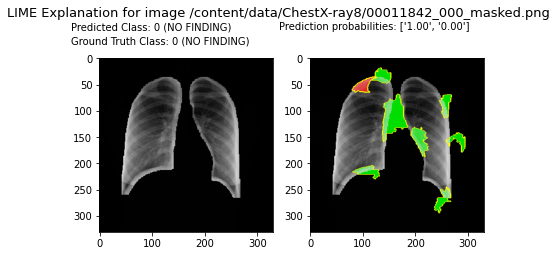


Intercept 1.3368997786859615
Prediction_local [0.63487815]
Right: 0.113419406
Intercept -0.33689975125530064
Prediction_local [0.36512182]
Right: 0.8865805
Explanation time = 121.447176 seconds


<Figure size 432x288 with 0 Axes>

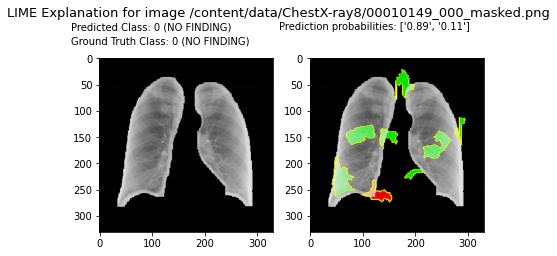


Intercept 1.2336533343408425
Prediction_local [0.71920375]
Right: 0.29342166
Intercept -0.233653329569943
Prediction_local [0.28079625]
Right: 0.7065783
Explanation time = 122.271189 seconds


<Figure size 432x288 with 0 Axes>

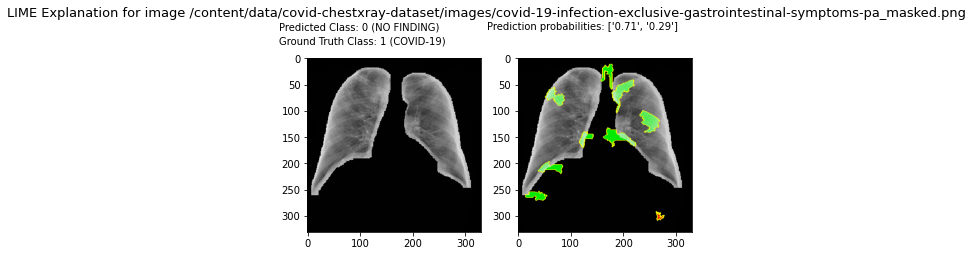


Intercept 1.4398128187002606
Prediction_local [0.14205101]
Right: 0.0011840041
Intercept -0.4398128245595412
Prediction_local [0.85794899]
Right: 0.998816
Explanation time = 120.261221 seconds


<Figure size 432x288 with 0 Axes>

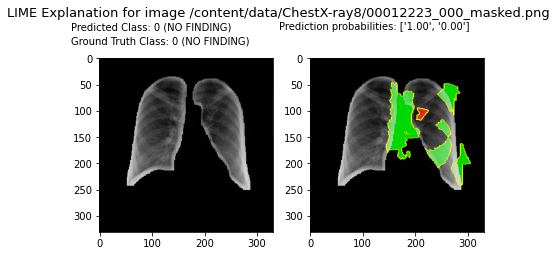


Intercept 1.43819356327842
Prediction_local [0.34887535]
Right: 0.25864938
Intercept -0.4381935428782291
Prediction_local [0.65112464]
Right: 0.7413506
Explanation time = 120.779688 seconds


<Figure size 432x288 with 0 Axes>

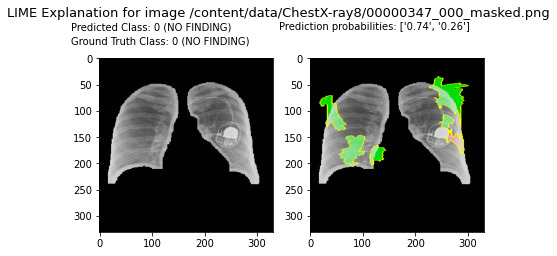


Intercept 1.3911546783173203
Prediction_local [-0.12316147]
Right: 0.028542161
Intercept -0.39115466701225443
Prediction_local [1.12316146]
Right: 0.9714578
Explanation time = 120.232333 seconds


<Figure size 432x288 with 0 Axes>

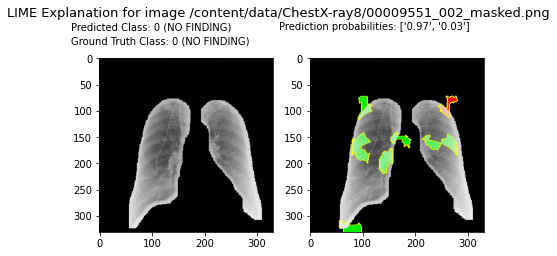


Intercept -0.0014496199918231163
Prediction_local [0.00724219]
Right: 0.0048409235
Intercept 1.0014496171775014
Prediction_local [0.99275781]
Right: 0.9951591
Explanation time = 120.707282 seconds


<Figure size 432x288 with 0 Axes>

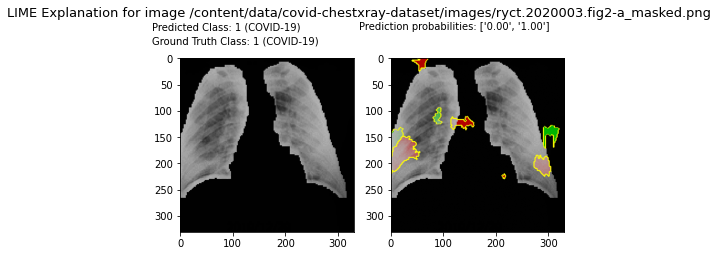


Intercept 0.009912219296693288
Prediction_local [0.02031502]
Right: 0.028843611
Intercept 0.9900878034253172
Prediction_local [0.97968496]
Right: 0.97115636
Explanation time = 121.079874 seconds


<Figure size 432x288 with 0 Axes>

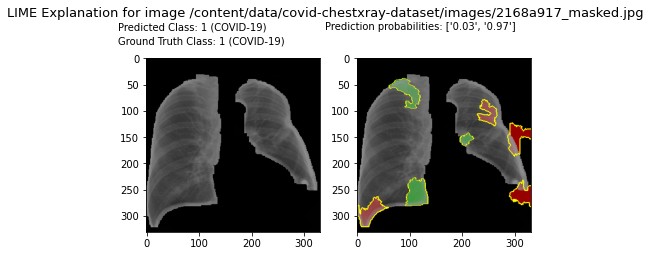


Intercept 0.06082388917083467
Prediction_local [0.16240822]
Right: 0.058333084
Intercept 0.9391761127090001
Prediction_local [0.83759178]
Right: 0.9416669
Explanation time = 120.135508 seconds


<Figure size 432x288 with 0 Axes>

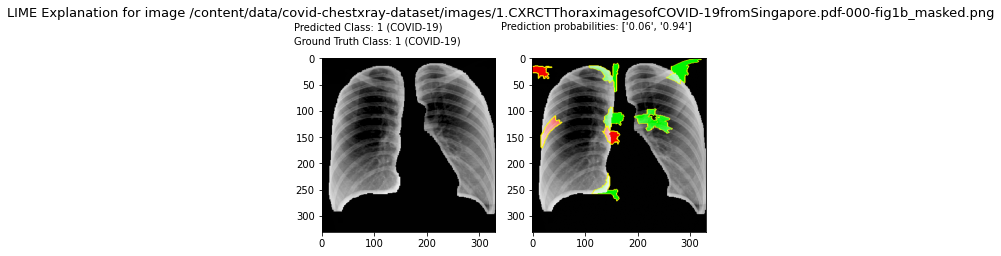


Intercept -0.11123886707932301
Prediction_local [0.19929671]
Right: 0.26101744
Intercept 1.1112388554678954
Prediction_local [0.8007033]
Right: 0.73898256
Explanation time = 121.063608 seconds


<Figure size 432x288 with 0 Axes>

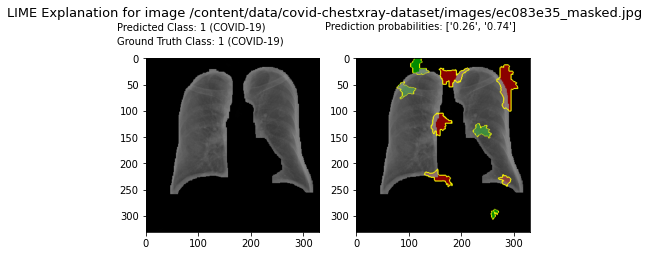


Intercept -0.10594875245466082
Prediction_local [0.15939999]
Right: 0.41859737
Intercept 1.1059487491087374
Prediction_local [0.84060001]
Right: 0.58140266
Explanation time = 120.504406 seconds


<Figure size 432x288 with 0 Axes>

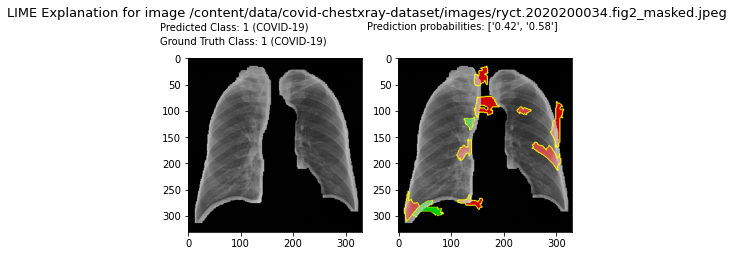


Intercept -0.053071176098729175
Prediction_local [0.10985574]
Right: 0.14612906
Intercept 1.0530711717071846
Prediction_local [0.89014426]
Right: 0.8538709
Explanation time = 120.813855 seconds


<Figure size 432x288 with 0 Axes>

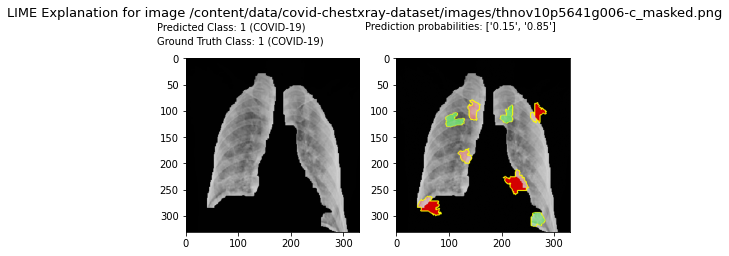


Intercept -0.07063070081770775
Prediction_local [0.07556329]
Right: 0.21310863
Intercept 1.0706307407570614
Prediction_local [0.92443667]
Right: 0.78689134
Explanation time = 119.621753 seconds


<Figure size 432x288 with 0 Axes>

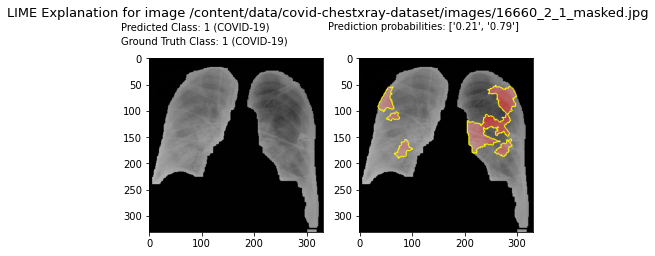


Intercept -0.13038514249154842
Prediction_local [0.18556933]
Right: 0.42493778
Intercept 1.130385142710962
Prediction_local [0.81443067]
Right: 0.5750623
Explanation time = 119.218575 seconds


<Figure size 432x288 with 0 Axes>

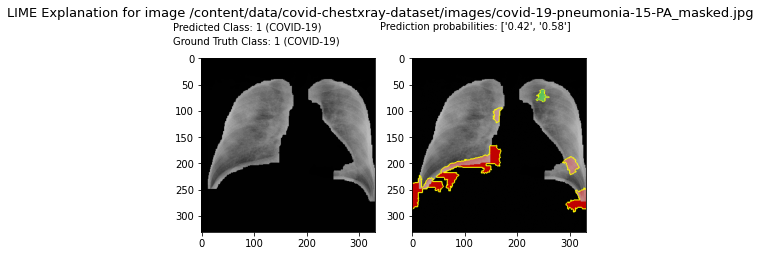


Intercept 1.2290819846139311
Prediction_local [0.69978678]
Right: 0.0644339
Intercept -0.22908196976187659
Prediction_local [0.30021321]
Right: 0.93556607
Explanation time = 119.287759 seconds


<Figure size 432x288 with 0 Axes>

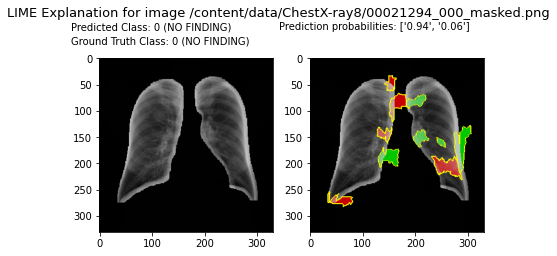


Intercept 1.3059387132017612
Prediction_local [0.50687077]
Right: 0.014268084
Intercept -0.30593872880920536
Prediction_local [0.49312925]
Right: 0.9857319
Explanation time = 120.244117 seconds


<Figure size 432x288 with 0 Axes>

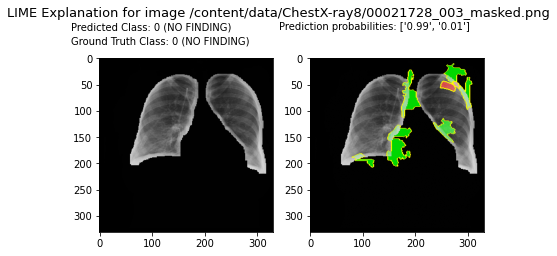


Intercept 1.1739381492636214
Prediction_local [0.40655418]
Right: 0.41517955
Intercept -0.1739381457407646
Prediction_local [0.59344582]
Right: 0.58482045
Explanation time = 119.243563 seconds


<Figure size 432x288 with 0 Axes>

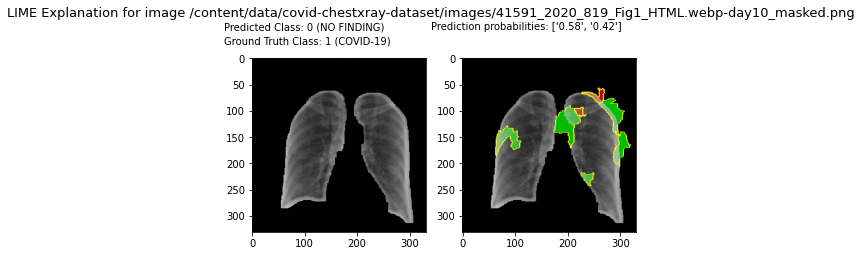


Intercept 0.9584859136487818
Prediction_local [0.22006798]
Right: 0.08333575
Intercept 0.04151409870682887
Prediction_local [0.77993201]
Right: 0.91666424
Explanation time = 119.402183 seconds


<Figure size 432x288 with 0 Axes>

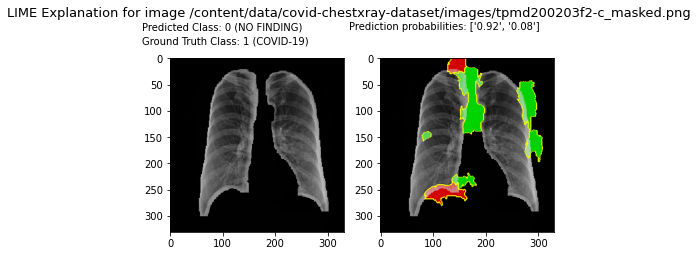


Intercept -0.0016453623616661769
Prediction_local [0.00168933]
Right: 0.005933459
Intercept 1.0016453876321765
Prediction_local [0.99831064]
Right: 0.9940665
Explanation time = 118.768986 seconds


<Figure size 432x288 with 0 Axes>

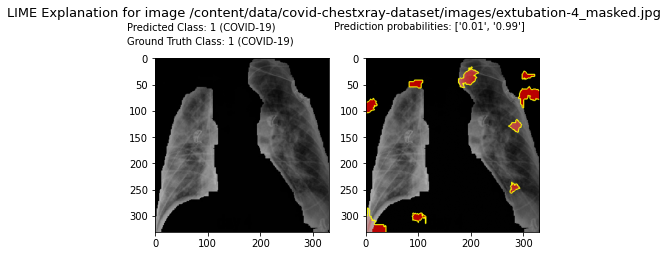


Intercept 1.2165289652140001
Prediction_local [0.02342142]
Right: 0.00872585
Intercept -0.21652899093093342
Prediction_local [0.97657861]
Right: 0.9912742
Explanation time = 120.069154 seconds


<Figure size 432x288 with 0 Axes>

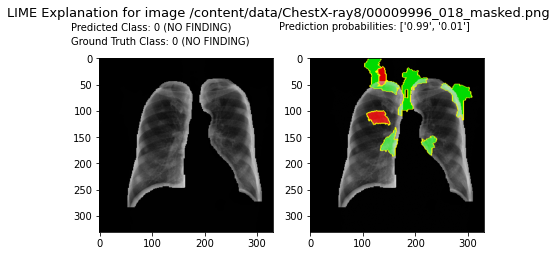


Intercept 0.01635620132611014
Prediction_local [0.04718797]
Right: 0.04988179
Intercept 0.9836437787615762
Prediction_local [0.95281205]
Right: 0.95011824
Explanation time = 115.92024 seconds


<Figure size 432x288 with 0 Axes>

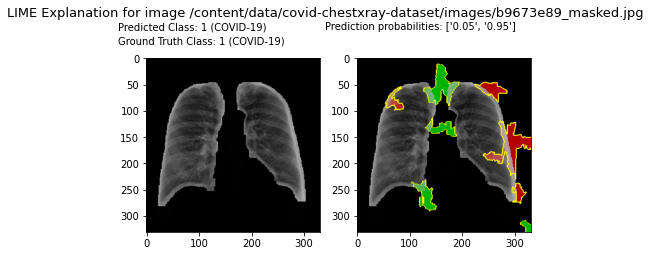


Intercept -0.034479923987882334
Prediction_local [0.06417452]
Right: 0.036644086
Intercept 1.0344799507284421
Prediction_local [0.93582545]
Right: 0.96335584
Explanation time = 119.208963 seconds


<Figure size 432x288 with 0 Axes>

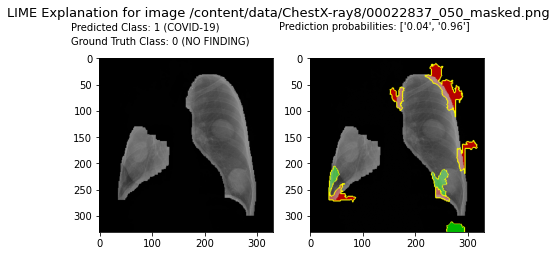


Intercept 1.326045949431814
Prediction_local [0.60284377]
Right: 0.22532164
Intercept -0.3260459640107711
Prediction_local [0.39715624]
Right: 0.7746784
Explanation time = 120.023399 seconds


<Figure size 432x288 with 0 Axes>

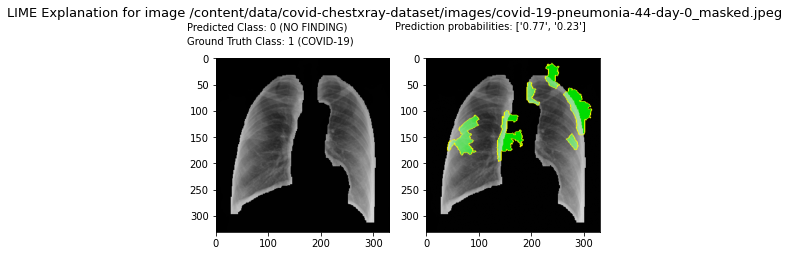


Intercept 0.0014613794695835596
Prediction_local [0.00214999]
Right: 0.0005898969
Intercept 0.9985385785177315
Prediction_local [0.99785005]
Right: 0.99941015
Explanation time = 118.390955 seconds


<Figure size 432x288 with 0 Axes>

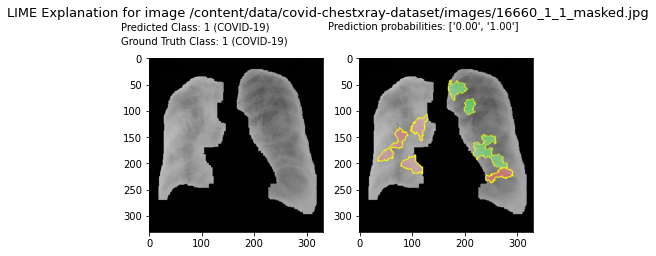


Intercept 1.100221410554121
Prediction_local [-0.07801808]
Right: 0.0048070126
Intercept -0.10022146211596827
Prediction_local [1.07801812]
Right: 0.995193
Explanation time = 118.552153 seconds


<Figure size 432x288 with 0 Axes>

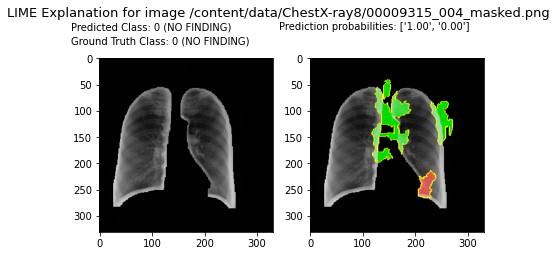


Intercept 1.022060751446078
Prediction_local [0.20399734]
Right: 0.11294202
Intercept -0.02206072704684131
Prediction_local [0.79600265]
Right: 0.88705796
Explanation time = 119.628891 seconds


<Figure size 432x288 with 0 Axes>

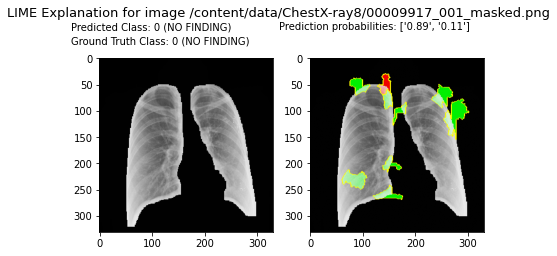


Intercept -0.08914316630126448
Prediction_local [0.14328835]
Right: 0.3077864
Intercept 1.0891431724752374
Prediction_local [0.85671164]
Right: 0.69221354
Explanation time = 118.459945 seconds


<Figure size 432x288 with 0 Axes>

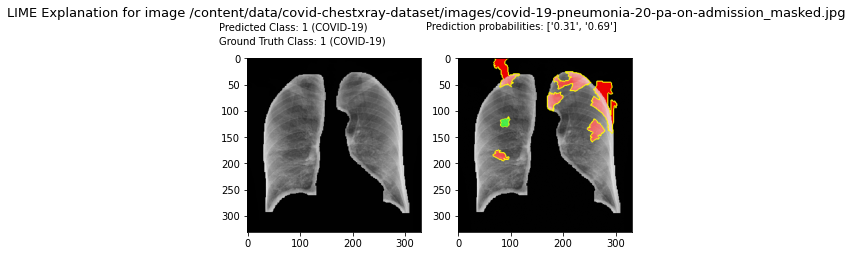


Intercept 0.10215478016250051
Prediction_local [0.18482584]
Right: 0.13159677
Intercept 0.8978452188292099
Prediction_local [0.81517416]
Right: 0.8684032
Explanation time = 123.446853 seconds


<Figure size 432x288 with 0 Axes>

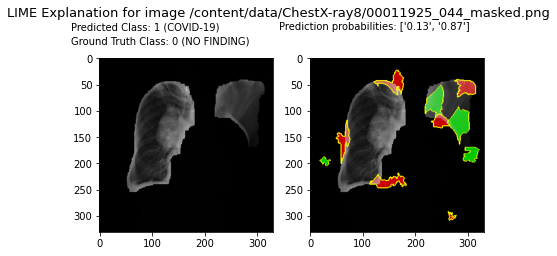


Intercept -0.07268488283793006
Prediction_local [0.17140144]
Right: 0.469011
Intercept 1.0726849006235981
Prediction_local [0.82859855]
Right: 0.530989
Explanation time = 118.990169 seconds


<Figure size 432x288 with 0 Axes>

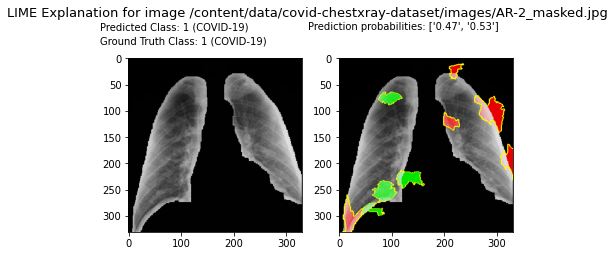


Intercept 1.3237579683229015
Prediction_local [0.09357327]
Right: 0.0115881
Intercept -0.3237579647915989
Prediction_local [0.90642672]
Right: 0.98841184
Explanation time = 119.418749 seconds


<Figure size 432x288 with 0 Axes>

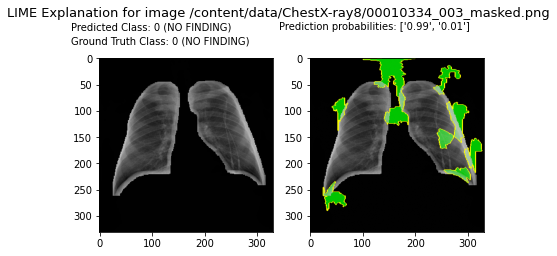


Intercept 1.3543776714047575
Prediction_local [0.07822702]
Right: 0.014176909
Intercept -0.35437763246440923
Prediction_local [0.92177294]
Right: 0.98582304
Explanation time = 123.030947 seconds


<Figure size 432x288 with 0 Axes>

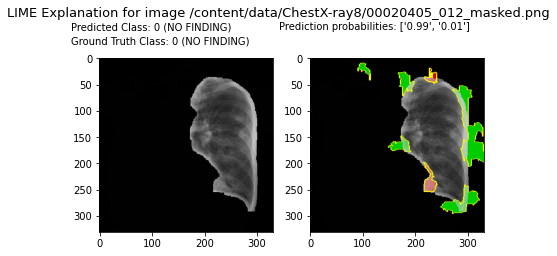


Intercept 1.4585629837512952
Prediction_local [0.11981619]
Right: 0.08422055
Intercept -0.4585629562066697
Prediction_local [0.88018378]
Right: 0.9157794
Explanation time = 120.373185 seconds


<Figure size 432x288 with 0 Axes>

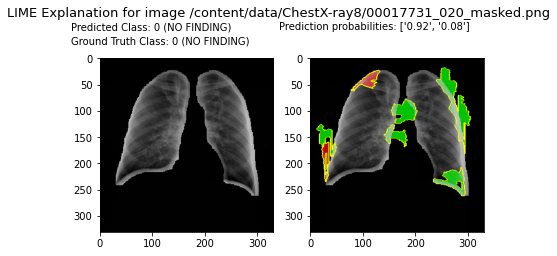


Intercept 1.3918925727613272
Prediction_local [0.08229018]
Right: 0.04667335
Intercept -0.3918925617018574
Prediction_local [0.91770981]
Right: 0.95332664
Explanation time = 119.112842 seconds


<Figure size 432x288 with 0 Axes>

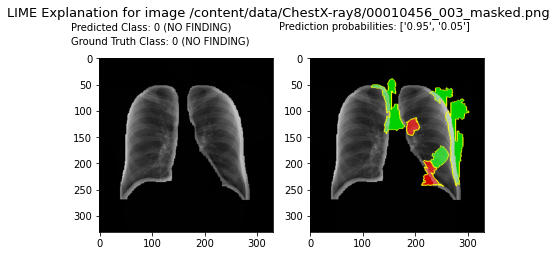


Intercept 0.1324929849798379
Prediction_local [0.02843523]
Right: 0.001017327
Intercept 0.8675069978165403
Prediction_local [0.97156479]
Right: 0.9989826
Explanation time = 119.120157 seconds


<Figure size 432x288 with 0 Axes>

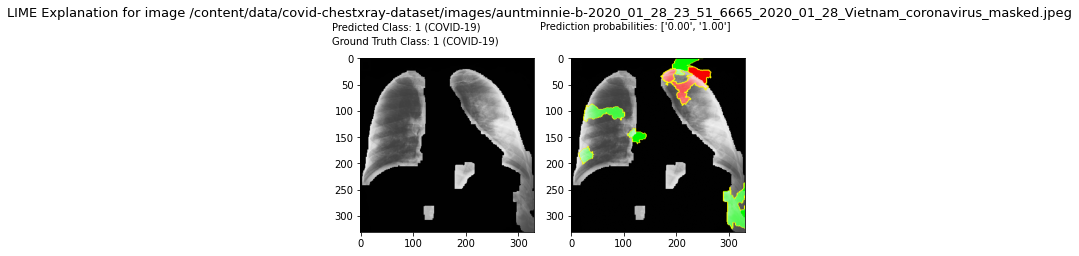


Intercept 1.309700836585827
Prediction_local [0.63298327]
Right: 0.06221853
Intercept -0.3097008612606026
Prediction_local [0.36701675]
Right: 0.93778145
Explanation time = 118.717354 seconds


<Figure size 432x288 with 0 Axes>

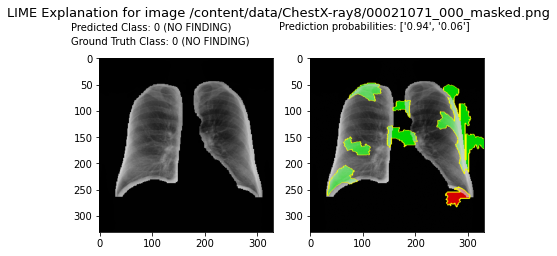


Intercept 0.7947469005246093
Prediction_local [0.34934149]
Right: 0.035242878
Intercept 0.20525309031651676
Prediction_local [0.65065852]
Right: 0.96475714
Explanation time = 118.887303 seconds


<Figure size 432x288 with 0 Axes>

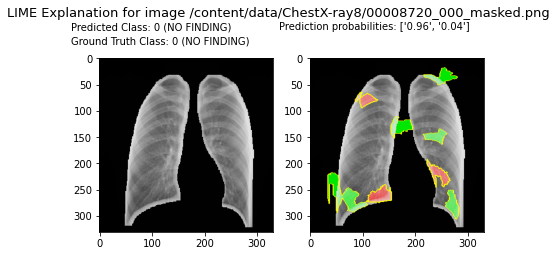


Intercept 0.08935280245478375
Prediction_local [0.05170275]
Right: 0.04342026
Intercept 0.910647230778354
Prediction_local [0.94829722]
Right: 0.9565797
Explanation time = 116.533373 seconds


<Figure size 432x288 with 0 Axes>

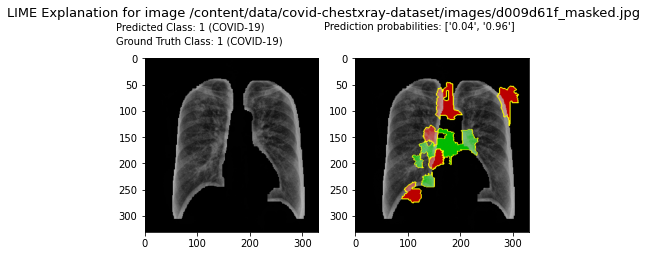


Intercept -0.0005045536886589525
Prediction_local [0.00095978]
Right: 0.0009776428
Intercept 1.0005045494128124
Prediction_local [0.99904022]
Right: 0.99902236
Explanation time = 120.627145 seconds


<Figure size 432x288 with 0 Axes>

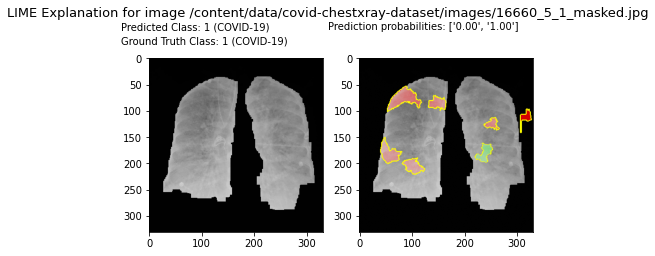


Intercept 1.2396919623154512
Prediction_local [0.71139351]
Right: 0.3912312
Intercept -0.2396919578444501
Prediction_local [0.28860648]
Right: 0.60876876
Explanation time = 121.811477 seconds


<Figure size 432x288 with 0 Axes>

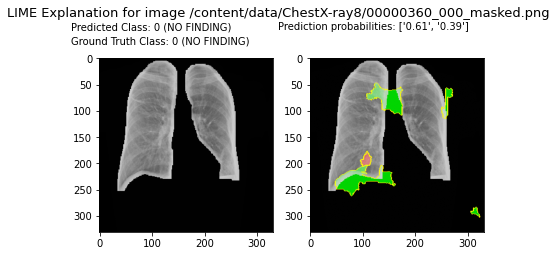

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries
from lime.lime_image import SegmentationAlgorithm

def visualize_explanation(orig_img, explanation, img_filename, label, probs, class_names, label_to_see='top', dir_path=None):

    if label_to_see == 'top':
        label_to_see = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(label_to_see, positive_only=False, num_features=10, hide_rest=False)
    return mark_boundaries(temp, mask)
    # Plot original image on the left
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig_img)

    # Plot the image and its explanation on the right
    if label_to_see == 'top':
        label_to_see = explanation.top_labels[0]
    explanation.image = orig_img
    temp, mask = explanation.get_image_and_mask(label_to_see, positive_only=False, num_features=10, hide_rest=False)
    ax[1].imshow(mark_boundaries(temp, mask))

    # Display some information about the example
    pred_class = np.argmax(probs)
    fig.text(0.5, 0.9, "Prediction probabilities: " + str(['{:.2f}'.format(probs[i]) for i in range(len(probs))]),
             fontsize=10)
    fig.text(0.02, 0.9, "Predicted Class: " + str(pred_class) + ' (' + class_names[int(pred_class)] + ')', fontsize=10)
    if label is not None:
        fig.text(0.02, 0.85, "Ground Truth Class: " + str(class_names.index(label)) + ' (' + label + ')', fontsize=10)
    fig.suptitle("LIME Explanation for image " + img_filename, fontsize=13)
    fig.tight_layout()
    plt.show()
    # Save the image
    filename = None
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        filename = os.path.join(dir_path, img_filename.split('/')[-1] + '_exp_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.svg')
        plt.savefig(filename)
    return filename

lime_test_generator.reset()
def get_lime_explanation(orig_img, label)
  x, _ = lime_test_generator.next()
  x = np.squeeze(x, axis=0)

  # Get the corresponding original image (no preprocessing)
  orig_img# = cv2.imread(data['TEST']['masked_filename'][idx])
  new_dim = (lime_dict['IMG_DIM'])
  orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

  # Make a prediction for this image and retrieve a LIME explanation for the prediction
  start_time = datetime.datetime.now()

  def predict(x):
      '''
      Helper function for LIME explainer. Runs model prediction on perturbations of the example.
      :param x: List of perturbed examples from an example
      :return: A numpy array constituting a list of class probabilities for each predicted perturbation
      '''
      y = lime_model.predict(x)  # Run prediction on the perturbations
      if y.shape[1] == 1:
          probs = np.concatenate([1.0 - y, y], axis=1)  # Compute class probabilities from the output of the model
      else:
          probs = y
      return probs

  # Algorithm for superpixel segmentation. Parameters set to limit size of superpixels and promote border smoothness
  segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=2.25, max_dist=50, ratio=0.1, sigma=0.15)
  # Generate explanation for the example
  explanation = lime_explainer.explain_instance(x.astype(np.double), predict, num_features=lime_dict['NUM_FEATURES'], num_samples=lime_dict['NUM_SAMPLES'], segmentation_fn=segmentation_fn)
  probs = predict(np.expand_dims(x, axis=0))

  print("Explanation time = " + str((datetime.datetime.now() - start_time).total_seconds()) + " seconds")

  # Get image filename and label
  img_filename = None #data['TEST']['masked_filename'][idx]
  label = None# data['TEST']['label'][idx]

  # Rearrange prediction probability vector to reflect original ordering of classes in project config
  probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_test_generator.class_indices]

  # Visualize the LIME explanation and optionally save it to disk
  file_path = lime_dict['IMG_PATH']
  explanation_filenames = []
  if lime_dict['COVID_ONLY'] == True:
      label_to_see = lime_test_generator.class_indices['COVID-19']
  else:
      label_to_see = 'top'
  expalanation_filename = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see,
                        dir_path=file_path)
  explanation_filenames.append(expalanation_filename)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(config['PATHS']['MODEL_TO_LOAD'], compile=False)

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

gradcam_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="masked_filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

img = gradcam_test_generator.next()


Found 39 validated image filenames belonging to 2 classes.


In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
   
class My_GradCAM:
  def __init__(self, model, classIdx, inner_model=None, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.inner_model = inner_model
    if self.inner_model == None:
      self.inner_model = model
    self.layerName = layerName 
    if self.layerName is None:
      self.layerName = self.find_target_layer()

  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.inner_model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")       

  def compute_heatmap(self, image, eps=1e-8):
    '''
    Computes heatmap of given image
    :return: heatmap
    '''
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = tf.keras.models.Model(
        inputs=[
            self.inner_model.inputs
        ],
        outputs=[
            self.inner_model.get_layer(self.layerName).output,
            self.inner_model.output
        ]
    )                                   
    
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, self.classIdx]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    heatmap = tf.reduce_mean(heatmap, axis=(0, 1))
    # return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0, dtype=cv2.CV_64F)

    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)
  

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/models/model_covid/model20200910-184019.h5', compile=False) 
segmented_model = load_model(config['PATHS']['MODEL_TO_LOAD'], compile=False) #segmented model

In [ ]:
!rm -R segmented_img/

In [ ]:
mkdir segmented_img

In [ ]:
mkdir segmented_vs_unsegmented

Found 39 validated image filenames belonging to 2 classes.
Found 39 validated image filenames belonging to 2 classes.


ValueError: ignored

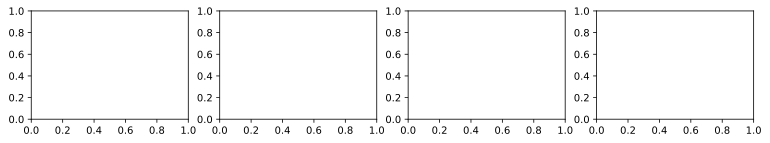

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

gradcam_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

gradcam_test_generator_masked = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="masked_filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

for i in range(len(data['TEST'])):
  f, axarr = plt.subplots(1, 4)
  f.set_figheight(2)
  f.set_figwidth(13)
  img, _ = gradcam_test_generator.next()
  masked_img, _ = gradcam_test_generator_masked.next()
  
  predict = model.predict(img)
  classIdx = np.argmax(predict)

  masked_predict = model.predict(masked_img)
  masked_classIdx = np.argmax(masked_predict)


  org_classIdx = data['TEST']['label'][i]
  org_img = load_img(data['TEST']['filename'][i])
  org_img = img_to_array(org_img)
  org_masked_img = load_img(data['TEST']['masked_filename'][i])
  org_masked_img = img_to_array(org_masked_img)

  cam = My_GradCAM(model, classIdx=classIdx, inner_model=model.get_layer("NASNet"), layerName=None)
  heatmap = cam.compute_heatmap(img)
  heatmap = tf.keras.preprocessing.image.img_to_array(heatmap)
  heatmap = cv2.resize(heatmap, img_shape)
  heatmap = cv2.resize(heatmap, org_img.shape[1::-1])

  (heatmap, output) = cam.overlay_heatmap(heatmap, org_img, alpha=0.3, colormap=cv2.COLORMAP_JET)

  masked_cam = My_GradCAM(segmented_model, classIdx=masked_classIdx, inner_model=model.get_layer("NASNet"), layerName=None)
  masked_heatmap = cam.compute_heatmap(masked_img)
  masked_heatmap = cv2.resize(masked_heatmap, img_shape)

  masked_heatmap = cv2.resize(masked_heatmap, org_img.shape[1::-1])


  jet = cm.get_cmap("jet")
  # We use RGB values of the colormap
  #heatmap = heatmap[:, :, 0]
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]
  # We create an image with RGB colorized heatmap
  print(heatmap.shape, jet_heatmap.shape, org_img.shape)
  print(jet_heatmap)
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(np.squeeze(jet_heatmap))
  jet_heatmap = jet_heatmap.resize((org_img.shape[1], org_img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + org_img
  #superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  masked_jet_heatmap = jet_colors[masked_heatmap]
  print(superimposed_img)
  print(masked_jet_heatmap.shape)
  # We create an image with RGB colorized heatmap
  '''mmasked_jet_heatmap = tf.keras.preprocessing.image.array_to_img(masked_jet_heatmap)
  asked_jet_heatmap = masked_jet_heatmap.resize((img_shape[1], img_shape[0]))
  masked_jet_heatmap = tf.keras.preprocessing.image.img_to_array(masked_jet_heatmap)

  # Superimpose the heatmap on original image
  masked_superimposed_img = masked_jet_heatmap * 0.4 + org_masked_img
  masked_superimposed_img = tf.keras.preprocessing.image.array_to_img(masked_superimposed_img)
'''
  #(masked_heatmap, masked_output) = cam.overlay_heatmap(masked_heatmap, org_img, alpha=0.3, colormap=cv2.COLORMAP_JET)
  #f.suptitle('{}'.format(data['TEST']['filename'][i]))
  axarr[0].imshow(org_img/255)
  #axarr[0].axis('off')
  axarr[0].set_yticks([])
  axarr[0].set_xticks([])
  axarr[0].set_xlabel('Unsegmented X-Ray')
  axarr[0].set_ylabel('Actual: {}'.format('COVID-19' if org_classIdx else 'NO FINDING'))
  axarr[1].imshow(superimposed_img/255)
  #axarr[1].axis('off')
  axarr[1].set_yticks([])
  axarr[1].set_xticks([])
  axarr[1].set_xlabel('Heatmap of unsegmented X-Ray')
  axarr[1].set_ylabel('Predicted: {}'.format('COVID-19' if classIdx else 'NO FINDING'))
  axarr[2].imshow(org_masked_img/255)
  #axarr[2].axis('off')
  axarr[2].set_yticks([])
  axarr[2].set_xticks([])
  axarr[2].set_xlabel('Segmented X-Ray')
  axarr[2].set_ylabel('Actual: {}'.format('COVID-19' if org_classIdx else 'NO FINDING'))
  axarr[3].imshow(masked_superimposed_img/255)
  #axarr[3].axis('off')
  axarr[3].set_yticks([])
  axarr[3].set_xticks([])
  axarr[3].set_xlabel('Heatmap of segmented X-Ray')
  axarr[3].set_ylabel('Predicted: {}'.format('COVID-19' if masked_classIdx else 'NO FINDING'))
  plt.savefig('/content/segmented_vs_unsegmented/image_{}.svg'.format(i), dpi=256)
  break

In [ ]:
mkdir gradcam_segmented_vs_unsegmented

In [ ]:
data['TEST']['filename'][26]

'/content/data/covid-chestxray-dataset/images/covid-19-pneumonia-20-pa-on-admission.jpg'

Found 39 validated image filenames belonging to 2 classes.
Found 39 validated image filenames belonging to 2 classes.
{'COVID-19': 0, 'NO FINDING': 1}


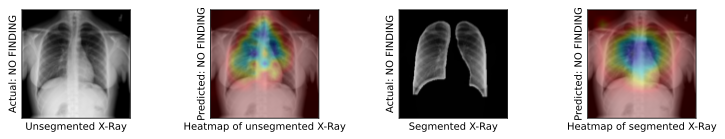

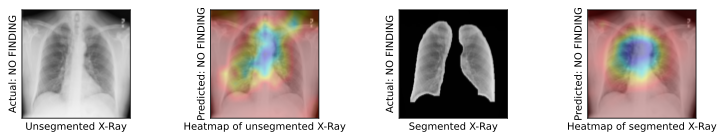

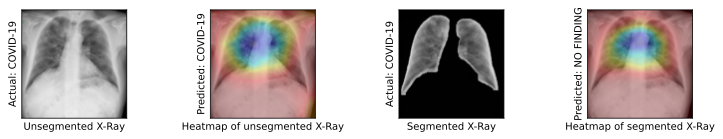

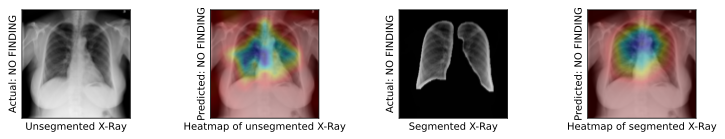

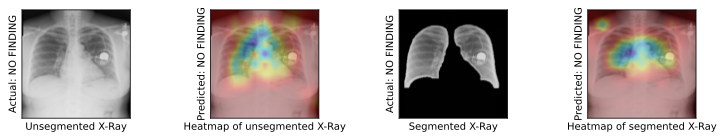

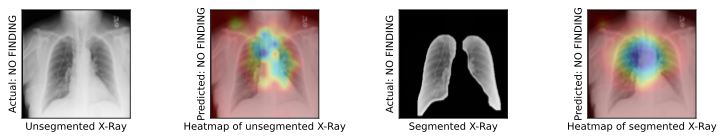

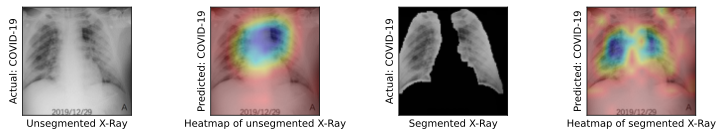

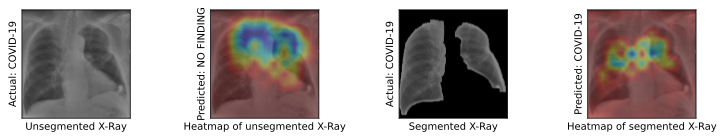

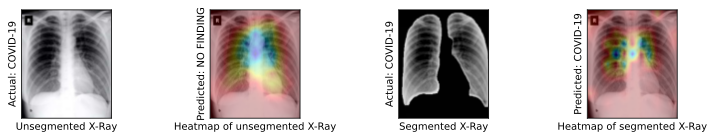

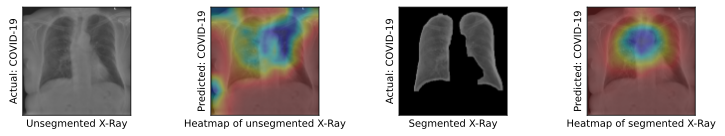

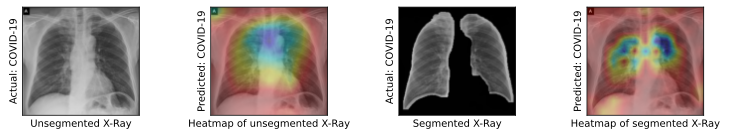

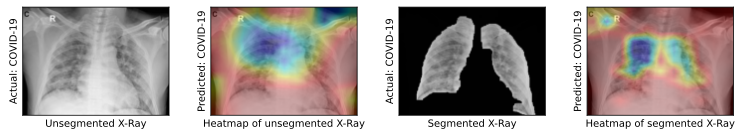

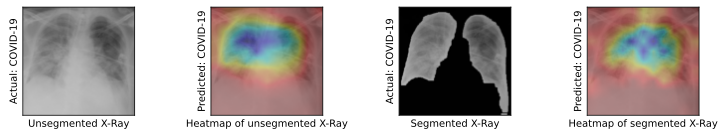

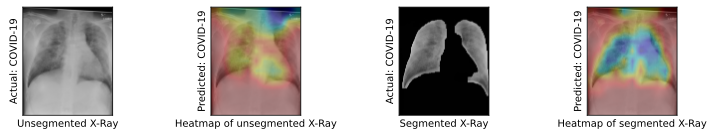

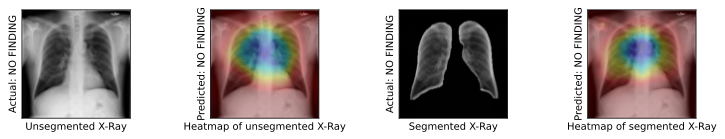

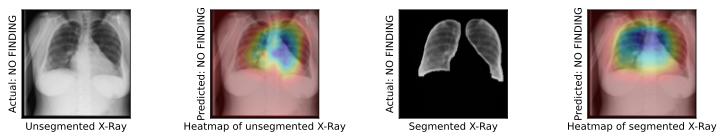

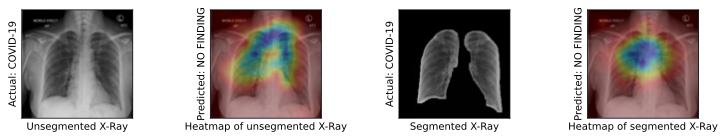

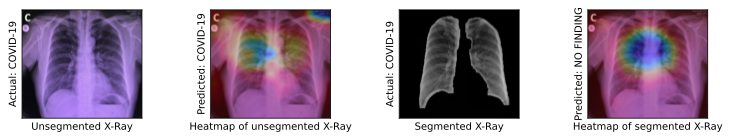

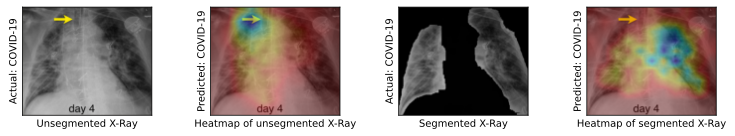

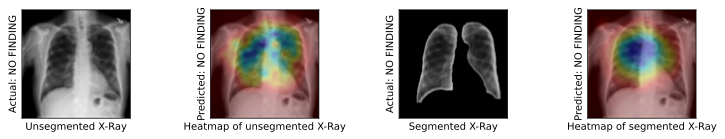

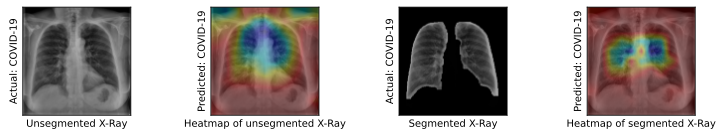

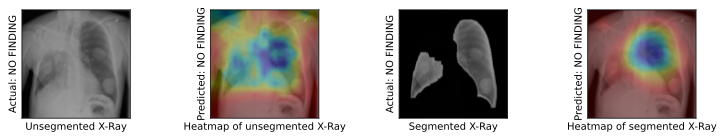

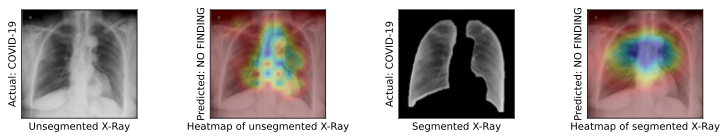

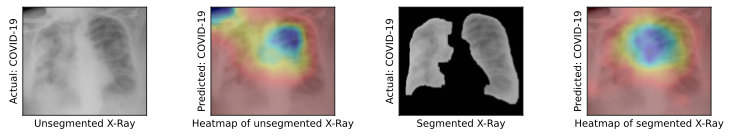

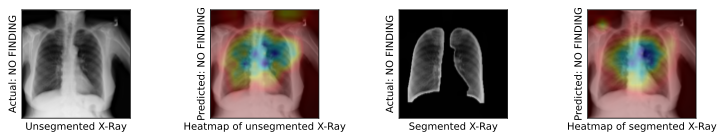

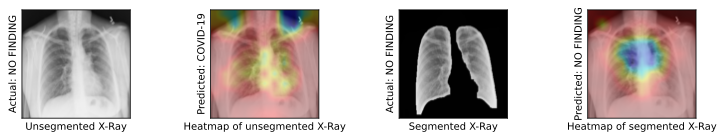

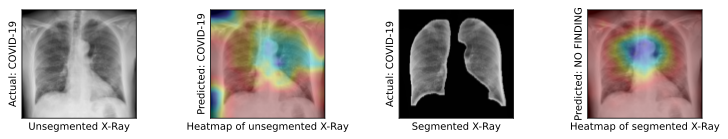

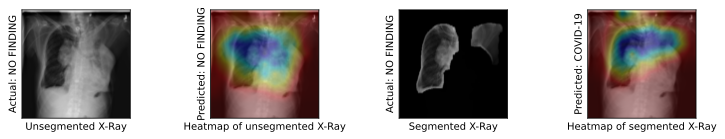

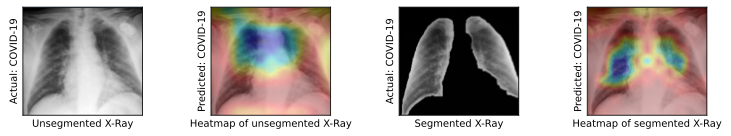

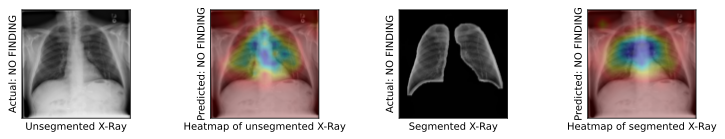

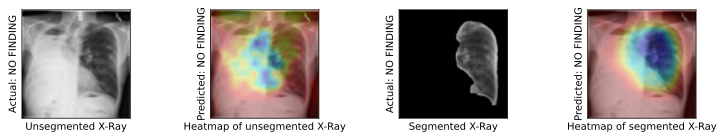

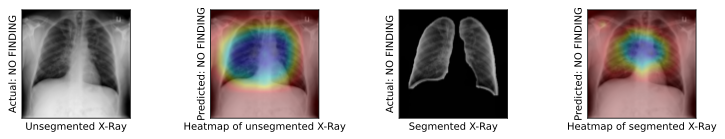

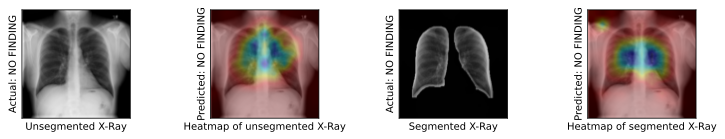

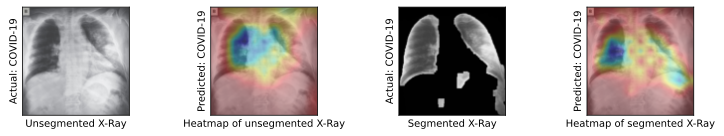

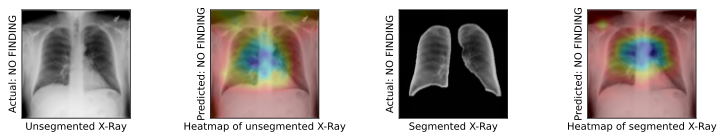

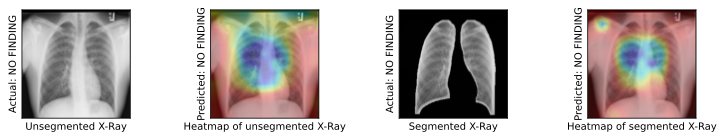

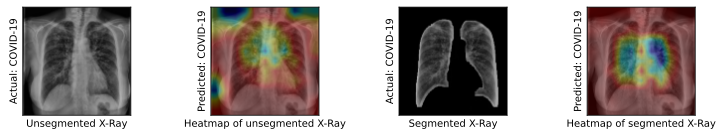

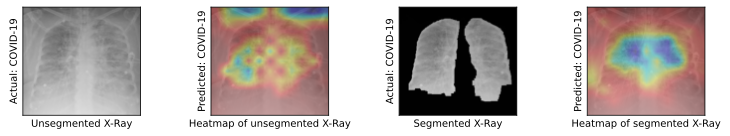

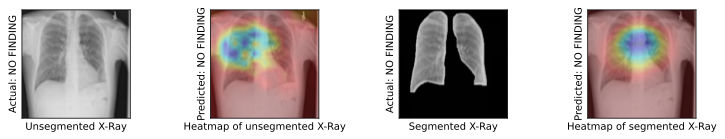

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

masked_test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

gradcam_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

gradcam_test_generator_masked = masked_test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="masked_filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

print(gradcam_test_generator.class_indices)

for i in range(len(data['TEST'])):
  f, axarr = plt.subplots(1, 4)
  f.set_figheight(2)
  f.set_figwidth(13)
  img, _ = gradcam_test_generator.next()
  masked_img, _ = gradcam_test_generator_masked.next()
  
  predict = model.predict(img)
  classIdx = np.argmax(predict)

  masked_predict = segmented_model.predict(masked_img)
  masked_classIdx = np.argmax(masked_predict)

  org_classIdx = data['TEST']['label'][i]
  org_img = load_img(data['TEST']['filename'][i])
  org_img = img_to_array(org_img)
  org_masked_img = load_img(data['TEST']['masked_filename'][i])
  org_masked_img = img_to_array(org_masked_img)

  cam = My_GradCAM(model, classIdx=classIdx, inner_model=model.get_layer("NASNet"), layerName=None)
  heatmap = cam.compute_heatmap(img)
  heatmap = cv2.resize(heatmap, img_shape)
  heatmap = cv2.resize(heatmap, org_img.shape[1::-1])

  (heatmap, output) = cam.overlay_heatmap(heatmap, org_img, alpha=0.3, colormap=cv2.COLORMAP_JET)

  masked_cam = My_GradCAM(segmented_model, classIdx=masked_classIdx, inner_model=segmented_model.get_layer("NASNet"), layerName=None)
  masked_heatmap = masked_cam.compute_heatmap(masked_img)
  masked_heatmap = cv2.resize(masked_heatmap, img_shape)

  masked_heatmap = cv2.resize(masked_heatmap, org_img.shape[1::-1])

  (masked_heatmap, masked_output) = masked_cam.overlay_heatmap(masked_heatmap, org_img, alpha=0.3, colormap=cv2.COLORMAP_JET)

  #f.suptitle('{}'.format(data['TEST']['filename'][i]))
  axarr[0].imshow(org_img/255)
  #axarr[0].axis('off')
  axarr[0].set_yticks([])
  axarr[0].set_xticks([])
  axarr[0].set_xlabel('Unsegmented X-Ray')
  axarr[0].set_ylabel('Actual: {}'.format(org_classIdx))
  axarr[1].imshow(output/255)
  #axarr[1].axis('off')
  axarr[1].set_yticks([])
  axarr[1].set_xticks([])
  axarr[1].set_xlabel('Heatmap of unsegmented X-Ray')
  axarr[1].set_ylabel('Predicted: {}'.format('NO FINDING' if classIdx else 'COVID-19'))
  axarr[2].imshow(org_masked_img/255)
  #axarr[2].axis('off')
  axarr[2].set_yticks([])
  axarr[2].set_xticks([])
  axarr[2].set_xlabel('Segmented X-Ray')
  axarr[2].set_ylabel('Actual: {}'.format(org_classIdx))
  axarr[3].imshow(masked_output/255)
  #axarr[3].axis('off')
  axarr[3].set_yticks([])
  axarr[3].set_xticks([])
  axarr[3].set_xlabel('Heatmap of segmented X-Ray')
  axarr[3].set_ylabel('Predicted: {}'.format('NO FINDING' if masked_classIdx else 'COVID-19'))
  plt.savefig('/content/gradcam_segmented_vs_unsegmented/classifier_{}.svg'.format(i), dpi=256)
  plt.show()


In [ ]:
import os

import numpy as np
from lime.lime_image import *
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from tensorflow.image import per_image_standardization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class LimeExplainer():
  """
  Utilizes a tensorflow.keras.Model from a given path.

  Attributes
  ----------
  model : tensorflow.keras.Model
      classification model
  kernel_width: float
      kernel width for the exponential kernel
  feature_selection: string
      feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'
  num_features: int
      maximum number of features present in explanation
  num_samples: int
      size of the neighborhood to learn the linear model
  explanation_prefix: string:
      prefix to prepend to heatmap overlayed image filename
  """

  def __init__(
        self,
        model,
        kernel_width,
        feature_selection,
        num_features = 1000,
        num_samples = 1000,
        explanation_prefix='explanation_',
        kernel_size=2.25,
        max_dist=50,
        ratio=0.1,
        sigma=0.15
    ):
    
    self.model = model
    self.KERNEL_WIDTH = kernel_width
    self.FEATURE_SELECTION = feature_selection
    self.image_size = (331, 331)
    self.num_features = num_features
    self.num_samples = num_samples
    self.exp = LimeImageExplainer(
      kernel_width=self.KERNEL_WIDTH,
      feature_selection=self.FEATURE_SELECTION
    )
    self.explanation_prefix = explanation_prefix
    self.kernel_size = kernel_size
    self.max_dist = max_dist
    self.ratio = ratio
    self.sigma = sigma

  def explain(self, image_path, display_image_path=None):
    """Return the file path of the explain X-Ray image classification.

    Creates an explanation for the given X-Ray image,
    visualizes the explanation utilizing a heatmap,
    saves the visualization in the same folder as 
    the original X-Ray image

    Args:
      image_path: path of the image to be classified and explained
      display_image_path: if set, use different image to underlay
        heatmap. Useful, when the image used for classification has
        already been modified in previous stages (e.g. segmentation)
    """
    orig_img = image.load_img(image_path, target_size = self.image_size)
    orig_img = np.asarray(orig_img, dtype=np.float64)
    orig_img = np.expand_dims(orig_img, axis = 0)
    standardized_img = per_image_standardization(orig_img)
    standardized_img = np.squeeze(standardized_img, axis=0)

    # create explanation
    explanation = self.__predict_and_explain(
      standardized_img,
      self.model,
      self.exp, 
      self.num_features,
      self.num_samples
    )

    if display_image_path is not None:
        # use different image to underlay heatmap
        orig_img = image.load_img(display_image_path, target_size = self.image_size)
        orig_img = np.asarray(orig_img, dtype=np.float64)
        orig_img = np.expand_dims(orig_img, axis = 0)
        orig_img = np.squeeze(orig_img, axis=0)
    else:
        orig_img = np.squeeze(orig_img, axis=0)

    # overlay heatmap
    visualization = self.__visualize_explanation(
      orig_img,
      explanation
    )
    return visualization
    # Save the image
    filename = None
    dir_path = os.path.dirname(image_path)
    img_filename = self.explanation_prefix + os.path.basename(image_path)
    if dir_path is not None:
      if not os.path.exists(dir_path):
          os.makedirs(dir_path)
      filename = os.path.join(dir_path, img_filename)
      imsave(filename, visualization)
    return filename
  

  def explain_batch(self, image_paths):
    """
    Creates explainations for each image specified in image_paths.
    :param image_paths: List of image paths. If tuple, second string
        sets display_image_path
    :return: List of paths of explained images
    """
    return [
        self.explain(image_path[0], image_path[1]) if isinstance(image_path, tuple) else self.explain(image_path)
        for image_path in image_paths
    ]
      
  
  def __predict_instance(self, x, model):
    """
    Runs model prediction on 1 or more input images.
    :param x: Image(s) to predict
    :param model: A Keras model
    :return: A numpy array comprising a list of class probabilities for each prediction
    """
    y = model.predict(x)  # Run prediction on the perturbations
    if y.shape[1] == 1:
        probs = np.concatenate([1.0 - y, y], axis=1)  # Compute class probabilities from the output of the model
    else:
        probs = y
    return probs

  def __predict_and_explain(self, x, model, exp, num_features, num_samples):
    """
    Use the model to predict a single example and apply LIME to generate an explanation.
    :param x: Preprocessed image to predict
    :param model: The trained neural network model
    :param exp: A LimeImageExplainer object
    :param num_features: # of features to use in explanation
    :param num_samples: # of times to perturb the example to be explained
    :return: explanation
    """

    def predict(x):
      """
      Helper function for LIME explainer. Runs model prediction on perturbations of the example.
      :param x: List of perturbed examples from an example
      :return: A numpy array constituting a list of class probabilities for each predicted perturbation
      """
      return self.__predict_instance(x, model)

    # Algorithm for superpixel segmentation. Parameters set to limit size of superpixels and promote border smoothness
    segmentation_fn = SegmentationAlgorithm(
        'quickshift',
        kernel_size=self.kernel_size,
        max_dist=self.max_dist,
        ratio=self.ratio,
        sigma=self.sigma
    )
    # Generate explanation for the example
    x = np.asarray(x)
    explanation = exp.explain_instance(
        x.astype(np.float64),
        predict,
        num_features=num_features,
        num_samples=num_samples,
        segmentation_fn=segmentation_fn
    )
    probs = self.__predict_instance(
        np.expand_dims(x, axis=0),
        model
    )
    return explanation

  def __visualize_explanation(self, orig_img, explanation):
    """
    Visualize an explanation for the prediction of a single X-ray image.
    :param orig_img: Original X-Ray image
    :param explanation: ImageExplanation object
    :return: explained image
    """

    label_to_see = explanation.top_labels[0]
    explanation.image = orig_img
    temp, mask = explanation.get_image_and_mask(
      label_to_see,
      positive_only=False, 
      num_features=10,
      hide_rest=False
    )

    explained_image = mark_boundaries(temp, mask)
    explained_image = explained_image.astype(np.uint8)
    return explained_image


In [ ]:
mkdir lime_segmented_vs_unsegmented

mkdir: cannot create directory ‘lime_segmented_vs_unsegmented’: File exists


Found 39 validated image filenames belonging to 2 classes.
Found 39 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


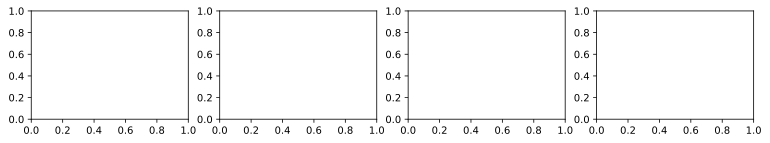

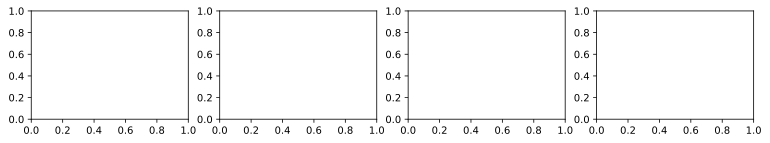

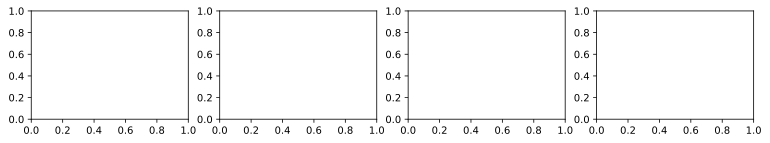

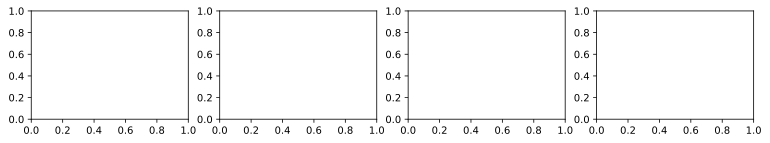

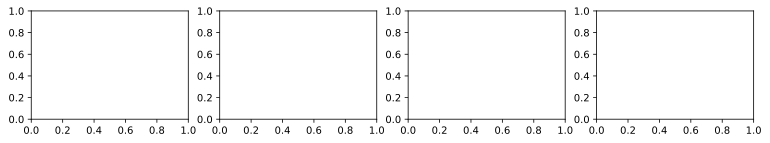

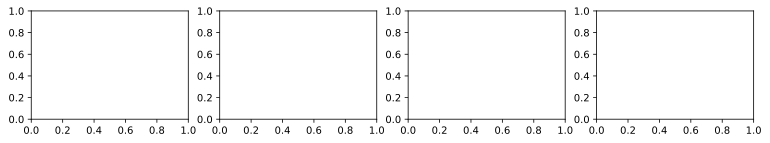

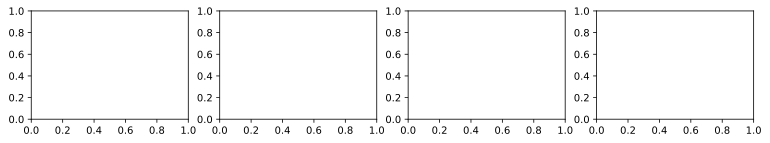

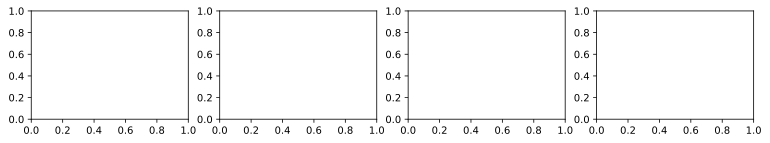

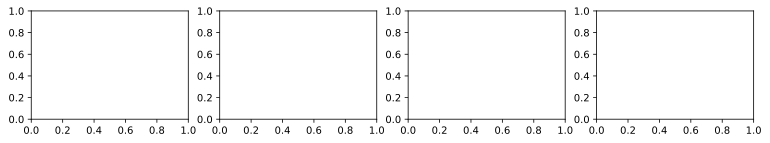

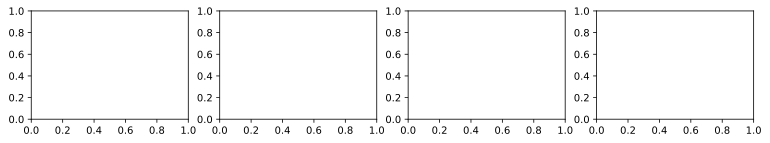

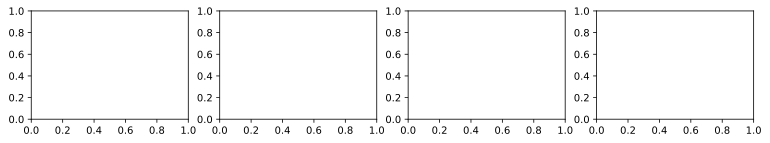

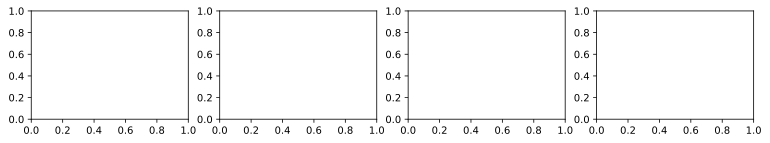

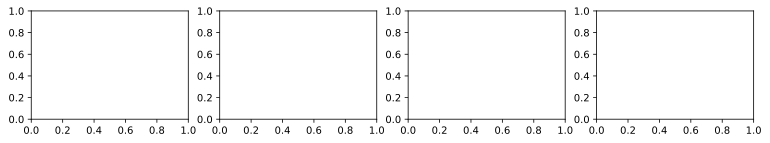

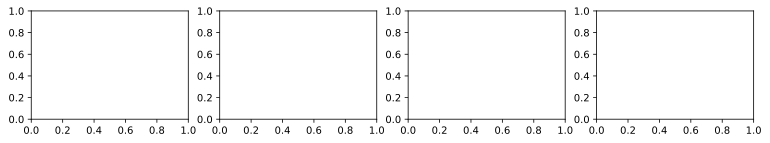

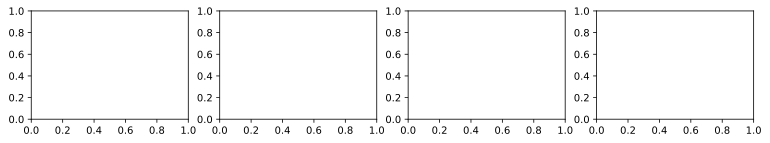

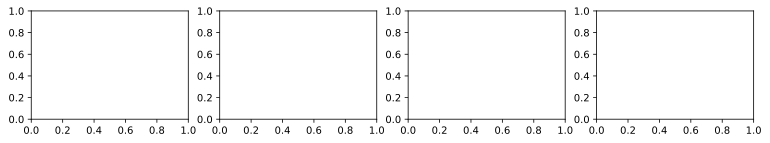

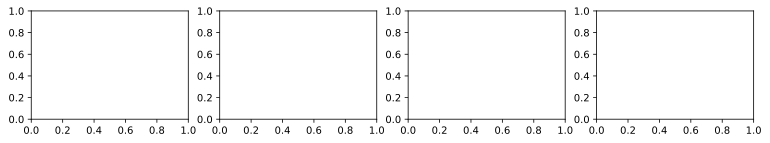

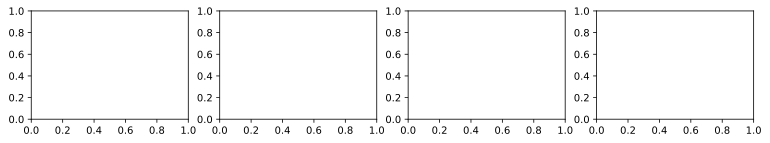

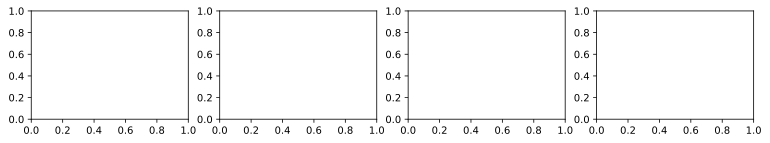

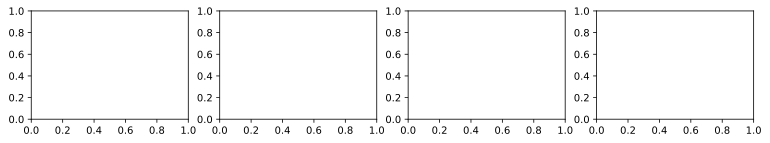

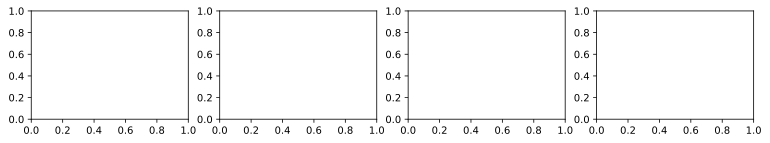

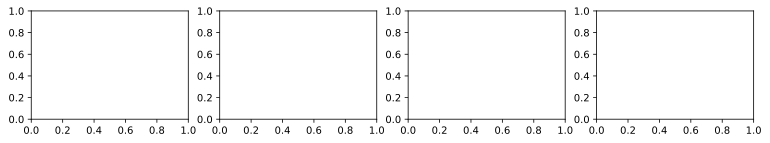

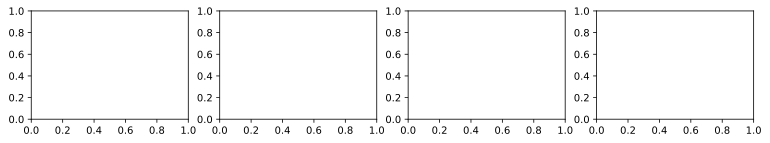

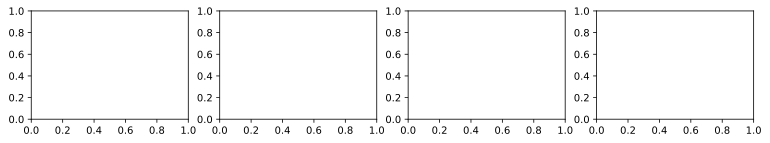

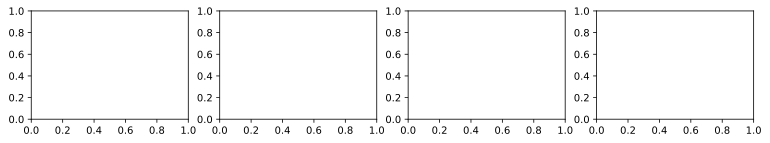

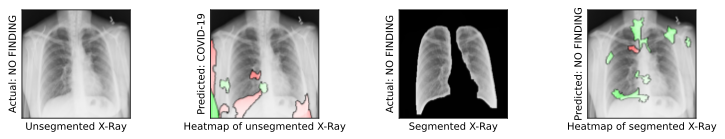

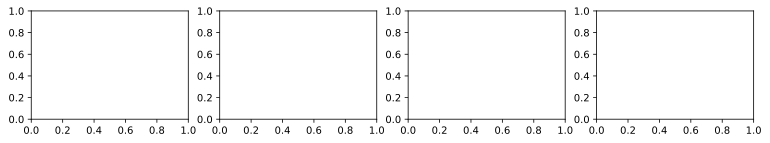

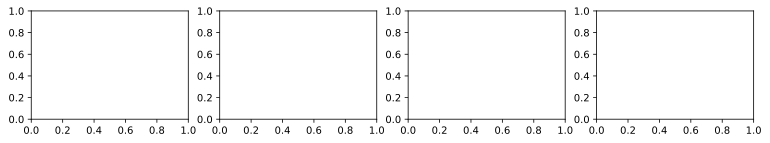

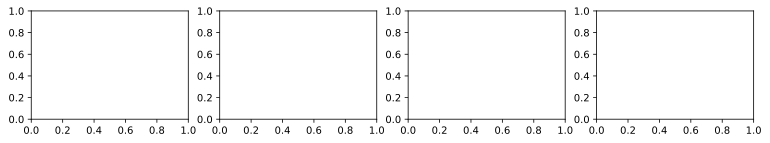

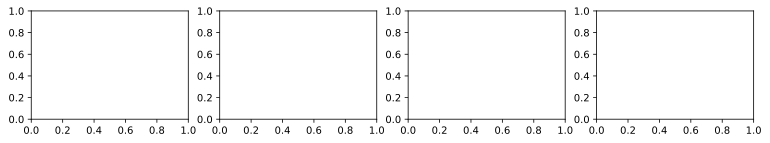

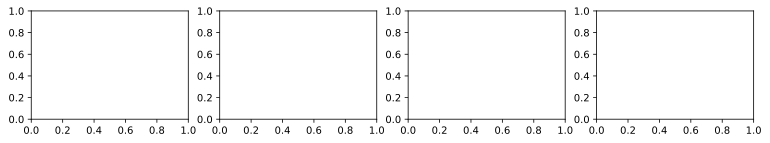

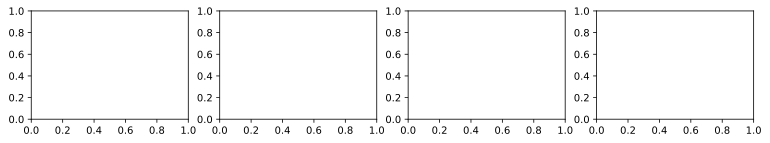

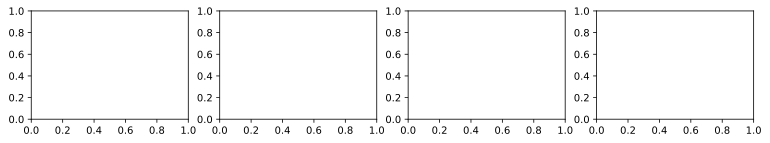

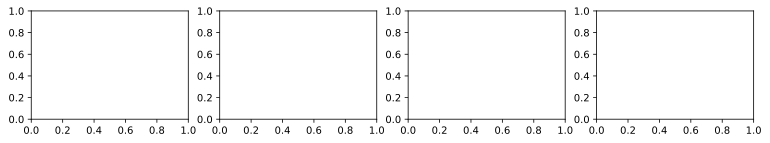

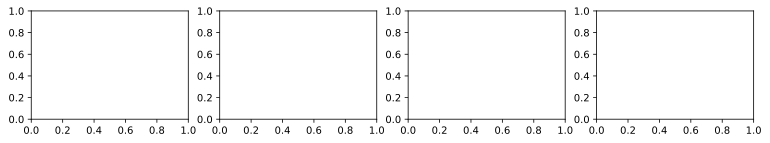

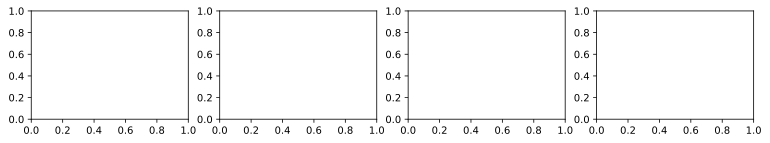

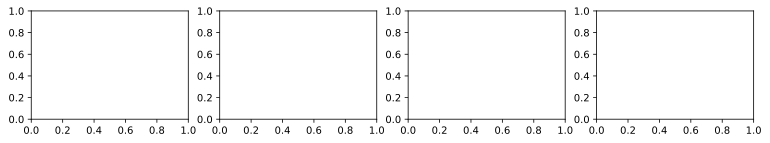

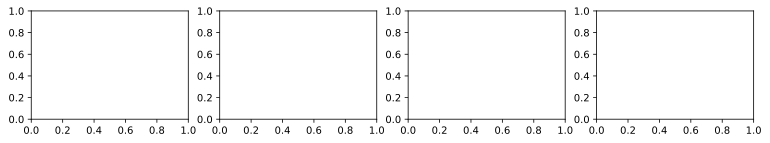

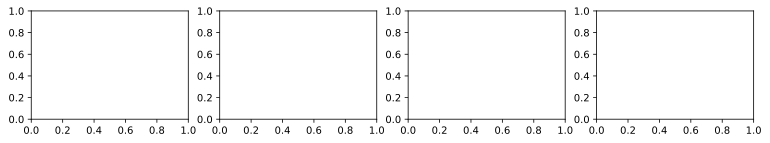

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import threading

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

gradcam_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

gradcam_test_generator_masked = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="masked_filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

lime_explainer = LimeExplainer(model, 4, 'lasso_path', kernel_size=2.5)
masked_lime_explainer = LimeExplainer(segmented_model, 4, 'lasso_path', kernel_size=2.5)

lime_img = []
masked_lime_img = []
for i in range(len(data['TEST'])):
  f, axarr = plt.subplots(1, 4)
  f.set_figheight(2)
  f.set_figwidth(13)
  img, _ = gradcam_test_generator.next()
  masked_img, _ = gradcam_test_generator_masked.next()
  if i != 25:
    continue
  predict = model.predict(img)
  classIdx = np.argmax(predict)

  masked_predict = segmented_model.predict(masked_img)
  masked_classIdx = np.argmax(masked_predict)

  org_classIdx = data['TEST']['label'][i]
  org_img = load_img(data['TEST']['filename'][i])
  org_img = img_to_array(org_img)
  org_masked_img = load_img(data['TEST']['masked_filename'][i])
  org_masked_img = img_to_array(org_masked_img)

  def ex_1():
    lime_img.append(lime_explainer.explain(data['TEST']['filename'][i]))
  def ex_2():
    masked_lime_img.append(masked_lime_explainer.explain(data['TEST']['masked_filename'][i], data['TEST']['filename'][i]))
  
  thread1 = threading.Thread(target=ex_1)
  thread2 = threading.Thread(target=ex_2)
  thread1.start()
  thread2.start()

  thread1.join()
  thread2.join()
  #f.suptitle('{}'.format(data['TEST']['filename'][i]))
  axarr[0].imshow(org_img/255)
  #axarr[0].axis('off')
  axarr[0].set_yticks([])
  axarr[0].set_xticks([])
  axarr[0].set_xlabel('Unsegmented X-Ray')
  axarr[0].set_ylabel('Actual: {}'.format(org_classIdx))
  axarr[1].imshow(lime_img[-1])
  #axarr[1].axis('off')
  axarr[1].set_yticks([])
  axarr[1].set_xticks([])
  axarr[1].set_xlabel('Heatmap of unsegmented X-Ray')
  axarr[1].set_ylabel('Predicted: {}'.format('COVID-19' if not classIdx else 'NO FINDING'))
  axarr[2].imshow(org_masked_img/255)
  #axarr[2].axis('off')
  axarr[2].set_yticks([])
  axarr[2].set_xticks([])
  axarr[2].set_xlabel('Segmented X-Ray')
  axarr[2].set_ylabel('Actual: {}'.format(org_classIdx))
  axarr[3].imshow(masked_lime_img[-1])
  #axarr[3].axis('off')
  axarr[3].set_yticks([])
  axarr[3].set_xticks([])
  axarr[3].set_xlabel('Heatmap of segmented X-Ray')
  axarr[3].set_ylabel('Predicted: {}'.format('COVID-19' if not masked_classIdx else 'NO FINDING'))
  plt.savefig('/content/lime_segmented_vs_unsegmented/image_{}.svg'.format(i), dpi=256)
  plt.show()


In [ ]:
print(data['TEST']['filename'][25])

/content/data/ChestX-ray8/00009917_001.png
